# Model Risk Management: ML model validation

## Transparency, Technical Robustness and Stability of AI models

A key to building interpretable models is to limit their complexity. The more complex a model is, the harder it is to explain and understand. Overly complex models can also make unstable predictions on new data, which is both difficult to explain and makes models harder to trust. **Monotonicity constraints** not only simplify models, but do so in a way that is somewhat natural for human reasoning, increasing the transparency of predictive models. Under monotonicity constraints, model predictions can only increase or only decrease as an input variable value increases, and the direction of the constraint is typically specified by the user for logical reasons. For instance, a model might be constrained to produce only increasing probabilities of a certain medical condition as a patient's age increases, or to make only increasing predictions for home prices as a home's square footage increases.

This notebook focuses on using sensitivity analysis to discover error mechanisms and security vulnerabilities and to assess stability and fairness in a trained XGBoost model. It begins by loading the UCI credit card default data. Then, Pearson correlation with the prediction target is used to determine the direction of the monotonicity constraints for each input variable. Then the training of an interpretable, **monotonically constrained XGBoost gradient boosting machine (GBM) model**. 

After the model is trained, global and local Shapley feature importance is calculated. These [Shapley values](https://christophm.github.io/interpretable-ml-book/shap.html) help inform the application of [partial dependence](https://christophm.github.io/interpretable-ml-book/pdp.html) and ICE ([Individual Conditional Expectation](https://christophm.github.io/interpretable-ml-book/ice.html)), and together these results guide a search for adversarial examples. This combination of monotonic XGBoost, partial dependence, ICE, and Shapley explanations is probably the most direct way to create an interpretable machine learning model today.

The notebook closes by exposing the trained model to a **random attack** and analyzing the attack results. These model debugging exercises uncover several accuracy, drift, and security problems such as over-emphasis of important features and non-robust interactions. Several remediation mechanisms are proposed:
 - including editing of final model outcomes 
 - missing value injection or regularization during training
 - use of assertions to inject missing values during scoring 

#### Python imports 

In [3]:
import numpy as np                        # array, vector, matrix calculations
import pandas as pd                       # DataFrame handling
import shap                               # for consistent, signed variable importance measurements
import xgboost as xgb                     # gradient boosting machines (GBMs)

from itertools import combinations        # n choose k combinations of objects
import string                             # for operations on character strings

pd.options.display.max_columns = 999      # enable display of all DataFrame columns in notebook

import matplotlib.pyplot as plt           # general plotting utilities
from mpl_toolkits.mplot3d import Axes3D   # for 3-D projections
from matplotlib import cm                 # colormaps for plots

# enables display of plots in notebook
%matplotlib inline

np.random.seed(42)                     # set random seed for global scope

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


## 1. Download, explore, and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The dataset contains 23 input variables: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005. Because XGBoost accepts only numeric inputs, all variables will be treated as numeric.

#### Import data and clean

In [4]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1) # skip the first row of the spreadsheet

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


#### Assign modeling roles

The shorthand name `y` is assigned to the prediction target. `X` is assigned to all other input variables in the credit card default data except the row identifier, `ID`.

In [5]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Display descriptive statistics
The input variables `SEX`, `EDUCATION`, `MARRIAGE`, `PAY_0`-`PAY_6`, and the prediction target `DEFAULT_NEXT_MONTH`, are categorical variables, but they have already been encoded into meaningful numeric, integer values, which is great for XGBoost. Also, there are no missing values in this dataset. 

In a traditional credit scoring environment, demographic variables like `SEX`, `EDUCATION`, `MARRIAGE` and `AGE` would not be used directly in the model, but only for disparate impact testing after model training. They are included in the model here for example purposes.

In [6]:
data[X + [y]].describe() # display descriptive statistics for all columns

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


**Note**: This notebook skips the usually mandatory explorative data analysis done prior to modelling in typical data science projects. 

## 2. Explainability

### 2.1 Investigate pair-wise Pearson correlations for `DEFAULT_NEXT_MONTH`

Monotonic relationships are much easier to explain to stakeholders such as management, clients and regulators than more complex, non-monotonic relationships. Furthermore, monotonic relationships may also prevent overfitting and excess error due to variance for new data.

To train a transparent monotonic classifier, constraints must be supplied to XGBoost that determine whether the learned relationship between an input variable and the prediction target `DEFAULT_NEXT_MONTH` will be increasing for increases in an input variable or decreasing for increases in an input variable. Pearson correlation provides a linear measure of the direction of the relationship between each input variable and the target. If the pair-wise Pearson correlation between an input and `DEFAULT_NEXT_MONTH` is positive, it will be constrained to have an increasing relationship with the predictions for `DEFAULT_NEXT_MONTH`. If the pair-wise Pearson correlation is negative, the input will be constrained to have a decreasing relationship with the predictions for `DEFAULT_NEXT_MONTH`. 

#### Calculate Pearson correlation

Because `DEFAULT_NEXT_MONTH` is the last column in the `data` DataFrame, the last column of the Pearson correlation matrix indicates the direction of the linear relationship between each input variable and the prediction target, `DEFAULT_NEXT_MONTH`. According to the obtained values, as a customer's balance limit (`LIMIT_BAL`), bill amounts (`BILL_AMT1`-`BILL_AMT6`), and payment amounts (`PAY_AMT1`-`PAY_AMT6`) increase, their probability of default tends to decrease. However as a customer's number of late payments increase (`PAY_0`, `PAY_2`-`PAY6`), their probability of default usually increases. In general, the Pearson correlation values make sense, and they will be used to ensure that the modeled relationships will make sense as well.

Pearson correlation values between the target variable, `DEFAULT_NEXT_MONTH`, and each input variable are displayed directly below.

In [7]:
# displays last column of Pearson correlation matrix as Pandas DataFrame
numeric_corr_y = pd.DataFrame(data[X + [y]].corr()[y]).iloc[:-1]
numeric_corr_y.sort_values(y,ascending=False)

,DEFAULT_NEXT_MONTH
PAY_0,0.324794
PAY_2,0.263551
PAY_3,0.235253
PAY_4,0.216614
PAY_5,0.204149
PAY_6,0.186866
EDUCATION,0.028006
AGE,0.013890
BILL_AMT6,-0.005372
BILL_AMT5,-0.006760


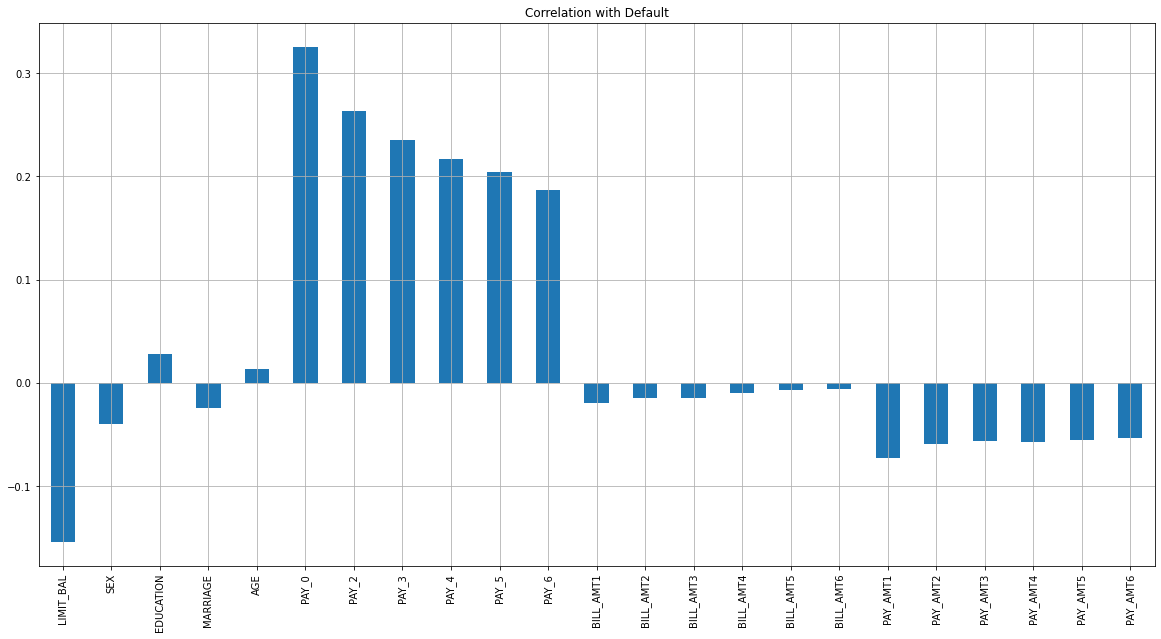

In [10]:
data[X].corrwith(data['DEFAULT_NEXT_MONTH']).plot.bar(
        figsize = (20, 10), title = "Correlation with Default",
        rot = 90, grid = True)

#### Create tuple of monotonicity constraints from Pearson correlation values

The last column of the Pearson correlation matrix is transformed from a numeric column in a Pandas DataFrame into a Python tuple of `1`s and `-1`s that will be used to specify monotonicity constraints for each input variable in XGBoost. If the Pearson correlation between an input variable and `DEFAULT_NEXT_MONTH` is positive, a positive montonic relationship constraint is specified for that variable using 1. If the correlation is negative, a negative monotonic constraint is specified using -1. (Specifying 0 indicates that no constraints should be used.) The resulting tuple will be passed to XGBoost when the GBM model is trained.

In [6]:
# creates a tuple in which positive correlation values are assigned a 1
# and negative correlation values are assigned a -1
mono_constraints = tuple([int(i) for i in np.sign(data[X + [y]].corr()[y].values[:-1])])
print(mono_constraints)

(-1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1)


### 2.2 Train XGBoost WITHOUT and WITH monotonicity constraints

XGBoost is a very accurate, open source GBM library for regression and classification tasks. XGBoost can learn complex relationships between input variables and a target variable, but here the `monotone_constraints` tuning parameter is used to enforce monotonicity between inputs and the prediction for `DEFAULT_NEXT_MONTH`. XGBoost's early stopping functionality is also used to limit overfitting to the training data

XGBoost is available from [dmlc](https://github.com/dmlc/xgboost) and the implementation of XGBoost is described in detail in this [paper](http://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf).

After training, Shapley variable importance is calculated and displayed. Shapley variable importance is a **global and local** measure of the contribution of an input variable to the GBM model predictions. The *global* variable importance values give an indication of the magnitude of a variable's contribution to model predictions for all observations. To enhance trust in the GBM model, variable importance values should typically conform to human domain knowledge and reasonable expectations.

#### Split data in training and test set

The credit card default data is split into training and test sets to monitor and prevent overtraining. **Reproducibility** is another important factor in creating trustworthy models, and randomly splitting datasets can introduce randomness in model predictions and other results. A random seed was set above to ensure the data split is reproducible.

In [7]:
split_ratio = 0.70    # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
test = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 21087, columns = 25
Test data rows = 8913, columns = 25


#### Train XGBoost GBM classifier WITHOUT monotone constraints

The reason we first develop the best possible model is so that we have a benchmark to compare explainable, robust, and fair models against.

For brevity's sake, a previously-discovered set of good tuning parameters are specified here. Because gradient boosting methods typically resample training data, an additional random seed is also specified for XGBoost using the `seed` parameter to create reproducible predictions, error rates, and variable importance values. To avoid overfitting, the `early_stopping_rounds` parameter is used to stop the training process after the test area under the curve (AUC) statistic fails to increase for 50 iterations.

In [8]:
# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas DataFrames 
dtrain = xgb.DMatrix(train[X], train[y])
dtest = xgb.DMatrix(test[X], test[y])

# used to calibrate predictions to mean of y 
base_y = train[y].mean()

# tuning parameters
params_base = {
    'objective': 'binary:logistic',             # produces 0-1 probabilities for binary classification
    'booster': 'gbtree',                        # base learner will be decision tree
    'eval_metric': 'auc',                       # stop training based on
    'eta': 0.08,                                # learning rate
    'subsample': 0.9,                           # use 90% of rows in each decision tree
    'colsample_bytree': 0.9,                    # use 90% of columns in each decision tree
    'max_depth': 15,                            # allow decision trees to grow to depth of 15
    'base_score': base_y,                       # calibrate predictions to mean of y 
    'seed': 4242                                # set random seed for reproducibility
}

# watchlist is used for early stopping
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# train model
xgb_model_base = xgb.train(params_base,         # set tuning parameters from above                   
                      dtrain,                   # training data
                      5000,                     # train up to 5000 iterations
                      evals=watchlist,          # use watchlist for early stopping 
                      early_stopping_rounds=50, # stop after 50 rounds of no increase in AUC in test set 
                      verbose_eval=True)        # display iteration progress


[0]	train-auc:0.88342	eval-auc:0.71629
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.90634	eval-auc:0.73375
[2]	train-auc:0.91741	eval-auc:0.74262
[3]	train-auc:0.92693	eval-auc:0.74727
[4]	train-auc:0.93389	eval-auc:0.75097
[5]	train-auc:0.93910	eval-auc:0.75305
[6]	train-auc:0.94414	eval-auc:0.75330
[7]	train-auc:0.95110	eval-auc:0.75485
[8]	train-auc:0.95441	eval-auc:0.75452
[9]	train-auc:0.95720	eval-auc:0.75546
[10]	train-auc:0.96023	eval-auc:0.75481
[11]	train-auc:0.96398	eval-auc:0.75518
[12]	train-auc:0.96676	eval-auc:0.75545
[13]	train-auc:0.96971	eval-auc:0.75617
[14]	train-auc:0.97198	eval-auc:0.75658
[15]	train-auc:0.97368	eval-auc:0.75773
[16]	train-auc:0.97571	eval-auc:0.75968
[17]	train-auc:0.97687	eval-auc:0.76060
[18]	train-auc:0.97908	eval-auc:0.76177
[19]	train-auc:0.98005	eval-auc:0.76163
[20]	train-auc:0.98095	eval-auc:0.76178
[21]	train-auc:0.98176	eval-a

The accuracy on the validation test is ca. 0.771.

#### Protected Values Prediction

One of the first questions we have to ask is whether our model prima facie suffers from social bias. To measure this we can predict the outcome of default by purely using protected values as features. The model includes the following attributes as features:
 - `SEX`
 - `EDUCATION`
 - `MARRIAGE`
 - `AGE`

In [9]:
sensitive = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE']

train_sens = train[sensitive]
train_sens["DEFAULT_NEXT_MONTH"] = train["DEFAULT_NEXT_MONTH"]

test_sens = test[sensitive]
test_sens["DEFAULT_NEXT_MONTH"] = test["DEFAULT_NEXT_MONTH"]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas DataFrames 
dtrain_sens = xgb.DMatrix(train_sens[sensitive], train_sens[y])
dtest_sens = xgb.DMatrix(test_sens[sensitive], test_sens[y])

# used to calibrate predictions to mean of y 
base_y = train_sens[y].mean()

# tuning parameters
params = {
    'objective': 'binary:logistic',             # produces 0-1 probabilities for binary classification
    'booster': 'gbtree',                        # base learner will be decision tree
    'eval_metric': 'auc',                       # stop training based on
    'eta': 0.08,                                # learning rate
    'subsample': 0.9,                           # use 90% of rows in each decision tree
    'colsample_bytree': 0.9,                    # use 90% of columns in each decision tree
    'max_depth': 15,                            # allow decision trees to grow to depth of 15
    'monotone_constraints':mono_constraints,    # 1 = increasing relationship, -1 = decreasing relationship
    'base_score': base_y,                       # calibrate predictions to mean of y 
    'seed': 4242                                # set random seed for reproducibility
}

# watchlist is used for early stopping
watchlist = [(dtrain_sens, 'train'), (dtest_sens, 'eval')]

# train model
xgb_model = xgb.train(params,                   # set tuning parameters from above                   
                      dtrain_sens,              # training data
                      5000,                     # train up to 5000 iterations
                      evals=watchlist,          # use watchlist for early stopping 
                      early_stopping_rounds=50, # stop after 50 rounds of no increase in AUC in test set 
                      verbose_eval=True)        # display iteration progress


[0]	train-auc:0.52424	eval-auc:0.52244
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.52495	eval-auc:0.52489
[2]	train-auc:0.52495	eval-auc:0.52489
[3]	train-auc:0.54715	eval-auc:0.53343
[4]	train-auc:0.54717	eval-auc:0.53321
[5]	train-auc:0.54709	eval-auc:0.53358
[6]	train-auc:0.54738	eval-auc:0.53371
[7]	train-auc:0.54718	eval-auc:0.53354
[8]	train-auc:0.54729	eval-auc:0.53388
[9]	train-auc:0.54734	eval-auc:0.53390
[10]	train-auc:0.54734	eval-auc:0.53390
[11]	train-auc:0.54737	eval-auc:0.53405
[12]	train-auc:0.54736	eval-auc:0.53387
[13]	train-auc:0.54735	eval-auc:0.53390
[14]	train-auc:0.54743	eval-auc:0.53397
[15]	train-auc:0.54743	eval-auc:0.53398
[16]	train-auc:0.54743	eval-auc:0.53398
[17]	train-auc:0.54745	eval-auc:0.53394
[18]	train-auc:0.54744	eval-auc:0.53394
[19]	train-auc:0.54745	eval-auc:0.53395
[20]	train-auc:0.54745	eval-auc:0.53394
[21]	train-auc:0.54752	eval-a

Because we are able to predict the default of a mortgage above average (0.5) using only protected (senstive) features, we can confirm that we have a socially biased model at the group level. Because the model predicts default, a loan would not be extended to these applicants. The main idea with bias mitigation is to discourage differences between protected and privileged categories, regardless of underlying difference in group circumstance. It is an equitable and compassionate policy that could reinvigorate a previously disadvantaged group. Immediate effects could translate to a privlidged group losing more advantages as well as short term profit decreases at the company level. These effects can be mitigated by applying a blanket rule to all companies, which would protect against non-compliant companies surviving due to short term profits as opposed to compliant companies. Equity doctrines could invigorate previously disadvantaged groups and could have substantial long-term economic benefits by getting them out of negative feedback loops.

#### Train XGBoost GBM classifier WITH monotone constraints

Notice that the monotonicity constraints are passed to XGBoost using the `monotone_constraints` parameter. 

In [11]:
# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas DataFrames 
dtrain = xgb.DMatrix(train[X], train[y])
dtest = xgb.DMatrix(test[X], test[y])

# used to calibrate predictions to mean of y 
base_y = train[y].mean()

# tuning parameters
params = {
    'objective': 'binary:logistic',             # produces 0-1 probabilities for binary classification
    'booster': 'gbtree',                        # base learner will be decision tree
    'eval_metric': 'auc',                       # stop training based on
    'eta': 0.08,                                # learning rate
    'subsample': 0.9,                           # use 90% of rows in each decision tree
    'colsample_bytree': 0.9,                    # use 90% of columns in each decision tree
    'max_depth': 15,                            # allow decision trees to grow to depth of 15
    'monotone_constraints':mono_constraints,    # 1 = increasing relationship, -1 = decreasing relationship
    'base_score': base_y,                       # calibrate predictions to mean of y 
    'seed': 4242                                # set random seed for reproducibility
}

# watchlist is used for early stopping
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# train model
xgb_model = xgb.train(params,                   # set tuning parameters from above                   
                      dtrain,                   # training data
                      5000,                     # train up to 5000 iterations
                      evals=watchlist,          # use watchlist for early stopping 
                      early_stopping_rounds=50, # stop after 50 rounds of no increase in AUC in test set 
                      verbose_eval=True)        # display iteration progress


[0]	train-auc:0.77371	eval-auc:0.75420
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.77559	eval-auc:0.75554
[2]	train-auc:0.77974	eval-auc:0.75920
[3]	train-auc:0.78030	eval-auc:0.76074
[4]	train-auc:0.78032	eval-auc:0.76060
[5]	train-auc:0.78173	eval-auc:0.76150
[6]	train-auc:0.78144	eval-auc:0.76173
[7]	train-auc:0.78261	eval-auc:0.76319
[8]	train-auc:0.78328	eval-auc:0.76390
[9]	train-auc:0.78363	eval-auc:0.76392
[10]	train-auc:0.78432	eval-auc:0.76454
[11]	train-auc:0.78525	eval-auc:0.76558
[12]	train-auc:0.78529	eval-auc:0.76613
[13]	train-auc:0.78589	eval-auc:0.76705
[14]	train-auc:0.78614	eval-auc:0.76724
[15]	train-auc:0.78647	eval-auc:0.76766
[16]	train-auc:0.78661	eval-auc:0.76815
[17]	train-auc:0.78680	eval-auc:0.76780
[18]	train-auc:0.78734	eval-auc:0.76781
[19]	train-auc:0.78776	eval-auc:0.76776
[20]	train-auc:0.78786	eval-auc:0.76806
[21]	train-auc:0.78801	eval-a

The accuracy on the validation test is ca. 0.769, so overall 1% lower than the original model without constraints. Therefore we will only concentrate on this model.

#### Interpretable Global Explanations: Global Shapley variable importance using Tree SHAP

Features with large absolute Shapley values are important. Since we want the global importance, we average the absolute Shapley values per feature across the data. By setting `pred_contribs=True`, XGBoost's `predict()` function will return Shapley values for each row of the test set.

Be sure to use the `ntree_limit=xgb_model.best_ntree_limit` option so that tree SHAP values are calculated for the best model. Also, the more trees, the slower the tree SHAP procedure! 

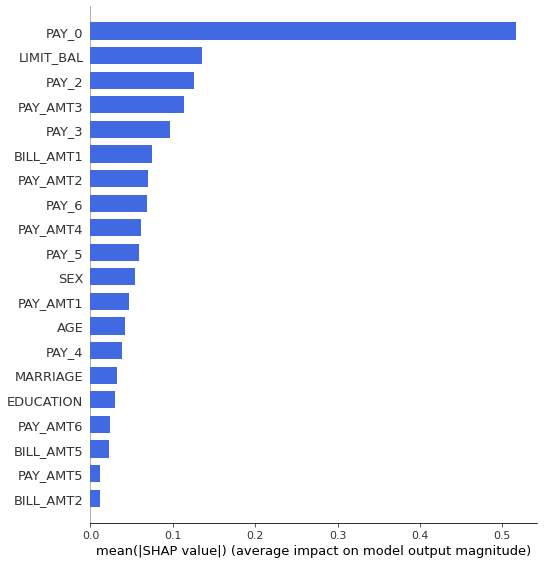

In [12]:
# shap_values
shap_values = xgb_model.predict(dtest, pred_contribs=True, ntree_limit=xgb_model.best_ntree_limit)

shap_values_plot_abs = shap_values[:,:-1]
shap.summary_plot(shap_values_plot_abs, X, plot_type='bar', color='royalblue')

In [13]:
shap_abs_mean = pd.DataFrame(shap_values_plot_abs, columns=list(X))
shap_abs_mean = shap_abs_mean.abs().mean().sort_values(ascending=False).to_frame()
shap_abs_mean.columns = ["SHAP Values"]; shap_abs_mean

,SHAP Values
PAY_0,0.516049
LIMIT_BAL,0.135081
PAY_2,0.126130
PAY_AMT3,0.114010
PAY_3,0.097106
BILL_AMT1,0.074282
PAY_AMT2,0.069666
PAY_6,0.068237
PAY_AMT4,0.061667
PAY_5,0.059094


#### Constraint Model: Display Shapley values for each input variable

We want to ensure that the values that would appear in our reason codes (all model constrained variables) are monotonic. One might first wonder why it won't be given that they have been constrained. The reasons is that they are still allowed to interact with other variables that are not monotonically constrained. So here we want to ensure that a reasonble level of monotonicity is maintained.

Instead of relying on traditional single-value variable importance measures, local Shapley values for each input will be plotted below to get a more holistic and consistent measurement for the global importance of each input variable. 

The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The SHAP value on the x-axis is the change in log-odds, this value is used because of its additive properties, and because it is able to have negative values. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance. 



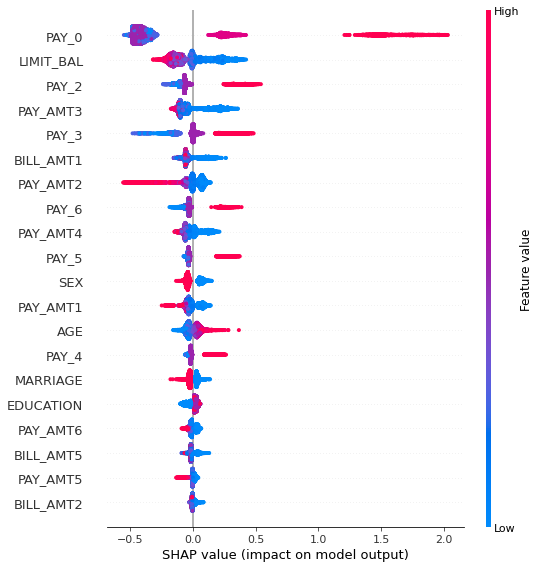

In [14]:
shap.summary_plot(shap_values[:, :-1], test[xgb_model.feature_names])

From the Shapley summary plot, it can be seen that `PAY_0`, or a customer's most recent repayment status, exerts a large influence on the model. High values of `PAY_0` are associated with large positive local contributions to model predictions. Low `PAY_0` values are associated with large negative local contributions to model predictions. `PAY_3`, or a customer's third most recent repayment status also seems to have a similar, but less intense, effect on the model predictions. `PAY_AMT1` and `PAY_AMT2`, a customer most and second-most recent payment amounts, display large negative local feature contributions. 

Visually, the values of the most variables, e.g. `LIMT_BAL`, `SEX` or `PAY_0` seem to be reasonably monotonic. The montonicity is guaged by looking at the gradual warming or cooling of colouring, without too many dots of anomalous discoloration from left to right or right to left. Nonwitstanding the above, I am still impressed with the model's mostly gradual movement from high to low values

#### Unconstraint Model: Display Shapley values for each input variable

The reason for the above constraints become clear when looking at the `PAY_0` here we can see a lot more discolouration on opposite sides of the zero.

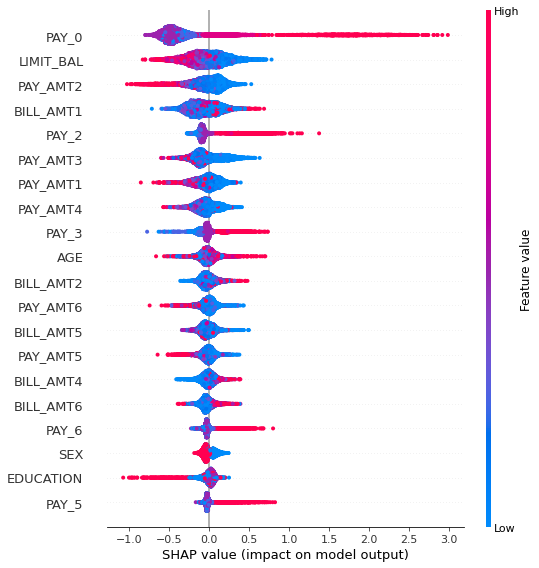

In [15]:
shap_values = xgb_model_base.predict(dtest, pred_contribs=True, ntree_limit=xgb_model_base.best_ntree_limit)
# plot Shapley variable importance summary 
shap.summary_plot(shap_values[:, :-1], test[xgb_model_base.feature_names])

These results will be used to guide and inform model debugging by **partial dependence**, **individual conditional expectation (ICE)**, and **adversarial examples** in the sections below.

#### Select a Probability Cutoff by Maximizing F1 Statistic

Cutoffs affect model characteristics, and sometimes drastically. Cutoffs should always be chosen with care. In this notebook, the cutoff is selected by maximizing the model's F1 statistic. This is a standard approach that could likely be improved upon.

Precision refers to the proportion of people the model predicts will default correctly out of the total number of predictions of default. Recall refers to the proportion of people the model predicts will default correctly out of the total number of actual defaults. F1 is a combination (harmonic mean) of these quantities. So by maximizing F1, a cutoff that considers true positives carefully is selected. The function below calculates precision, recall, and F1 at a number of probability cutoffs between 0 and 1. Results are displayed below.

In [59]:
# shortcut name
yhat = 'p_DEFAULT_NEXT_MONTH' 

# copy test data and reset index
test_yhat = test.copy(deep=True)
test_yhat.reset_index(drop=True, inplace=True) # Pandas joins are weird otherwise
test_yhat[yhat] = pd.DataFrame(xgb_model.predict(xgb.DMatrix(test[X]))) 

In [60]:
def get_prauc(frame, y, yhat, pos=1, neg=0, res=0.01):
    
    """ Calculates precision, recall, and f1 for a pandas dataframe of y 
        and yhat values.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        pos: Primary target value, default 1.
        neg: Secondary target value, default 0.
        res: Resolution by which to loop through cutoffs, default 0.01.
    
    Returns:
        Pandas dataframe of precision, recall, and f1 values.
        
    """
    
    frame_ = frame.copy(deep=True) # don't destroy original data
    dname = 'd_' + str(y)          # column for predicted decisions
    eps = 1e-20                    # for safe numerical operations
    
    # init p-r roc frame
    prroc_frame = pd.DataFrame(columns=['cutoff', 'recall', 'precision', 'f1'])
    
    # loop through cutoffs to create p-r roc frame
    for cutoff in np.arange(0, 1 + res, res):

        # binarize decision to create confusion matrix values
        frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
        
        # calculate confusion matrix values
        tp = frame_[(frame_[dname] == pos) & (frame_[y] == pos)].shape[0]
        fp = frame_[(frame_[dname] == pos) & (frame_[y] == neg)].shape[0]
        tn = frame_[(frame_[dname] == neg) & (frame_[y] == neg)].shape[0]
        fn = frame_[(frame_[dname] == neg) & (frame_[y] == pos)].shape[0]

        # calculate precision, recall, and f1
        recall = (tp + eps)/((tp + fn) + eps)
        precision = (tp + eps)/((tp + fp) + eps)
        f1 = 2/((1/(recall + eps)) + (1/(precision + eps)))
        
        # add new values to frame
        prroc_frame = prroc_frame.append({'cutoff': cutoff,
                                          'recall': recall,
                                          'precision': precision,
                                          'f1': f1}, 
                                          ignore_index=True)
    
    # housekeeping
    del frame_
    
    return prroc_frame

# calculate and display recall and precision
prauc_frame = get_prauc(test_yhat, y, yhat)
prauc_frame.style.set_caption('Recall and Precision')

,cutoff,recall,precision,f1
0,0.000000,1.000000,0.225289,0.367732
1,0.010000,0.999502,0.225632,0.368156
2,0.020000,0.998008,0.226928,0.369776
3,0.030000,0.995518,0.228902,0.372219
4,0.040000,0.991534,0.232024,0.376051
5,0.050000,0.986554,0.236227,0.381181
6,0.060000,0.976096,0.243025,0.389159
7,0.070000,0.958665,0.251996,0.399088
8,0.080000,0.936753,0.266619,0.415094
9,0.090000,0.906873,0.279809,0.427666


In [61]:
gbm_cut = prauc_frame.loc[prauc_frame['f1'].idxmax(), 'cutoff'] # value associated w/ index of max. F1
print('Best F1 threshold: %.2f' % gbm_cut)

Best F1 threshold: 0.25


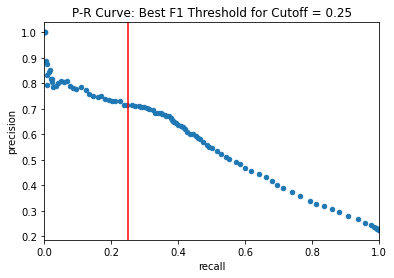

In [64]:
title_ = 'P-R Curve: Best F1 Threshold for Cutoff = ' + str(gbm_cut)
ax = prauc_frame.plot(x='recall', y='precision', kind='scatter', title=title_, xlim=[0,1])
_ = ax.axvline(gbm_cut, color='r')

In [69]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

y_pred_prob_lgb = xgb_model.predict(xgb.DMatrix(test[X]))
y_pred_gs_lgb = np.where(y_pred_prob_lgb>gbm_cut,1,0)

print(classification_report(test[y], y_pred_gs_lgb))

print('Precision is:'+str(round(precision_score(test[y], y_pred_gs_lgb),2)))
print('Recall is:'+str(round(recall_score(test[y], y_pred_gs_lgb, average='binary'),2)))
print('F1 score is:'+str(round(f1_score(test[y], y_pred_gs_lgb, average='binary'),2)))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      6905
           1       0.49      0.57      0.53      2008

    accuracy                           0.77      8913
   macro avg       0.68      0.70      0.69      8913
weighted avg       0.78      0.77      0.78      8913

Precision is:0.49
Recall is:0.57
F1 score is:0.53


In [73]:
!pip install pandasvault
import pandasvault as pv
pv.classification_scores(test[y], y_pred_gs_lgb, y_pred_prob_lgb)

  Created wheel for pandasvault: filename=pandasvault-0.0.3-py3-none-any.whl size=6497 sha256=84c10a46948015650bc5c153295a7c77f09ec3394a22e39d3b40a72633f35813
  Stored in directory: c:\users\alexandru\appdata\local\pip\cache\wheels\e6\69\47\fb358c31db1db42ec12c62098d21167b444fe5d56d6c0fb06e
Successfully built pandasvault


You should consider upgrading via the 'c:\users\alexandru\anaconda3\python.exe -m pip install --upgrade pip' command.


0.7706720520587905
0.7679489500362057


,Metrics
Average Log Likelihood,0.442039
Brier Score Loss,0.138922
Accuracy Score,0.770672
ROC AUC Sore,0.767949
Average Precision Score,0.543477
Precision - Bankrupt Firms,0.492301
False Positive Rate (p-value),0.171904
Precision - Healthy Firms,0.869658
False Negative Rate (recall error),0.426793
False Discovery Rate,0.507699


 ### 2.3 Partial Dependence and ICE to validate and explain monotonic behavior
 
In general **partial dependence** is used to understand the average predictions of a model across the domain of one or more input variable(s). This alone is very helpful information from a model debugging perspective. A user can see generally when a model is making high predictions and low predictions and if this prediction behavior makes sense from an accuracy standpoint. You can also begin to understand the sensitivity of a model to any given input variable. If partial dependence swings widely across the domain of a given variable, the model predictions are likely sensitive to the values of this variable and this variable would be expected to have high importance in the model. 

Even if the model predictions are suitably accurate, being highly sensitive to the values of an input variable can present disparate impact, security and stability problems. If a model's average predictions, as illustrated by partial dependence, are different across different races, genders, disability statuses or other sensitive demographic attributes, this is likely cause for a deeper analysis into the observational fairness of the model's prediction behavior, such as a disparate impact analysis.  Being highly sensitive to the values of any one input variable is also worrisome due to model drift and the ease with which an adversary could game the model predictions. Once a model is deployed, it's input variable values will likely drift as the real-world environment changes. Partial dependence can show us approximately how a model may react when drift occurs. If the model's simulated drift behavior is problematic, these drift patterns should be monitored closely after the model is deployed. 

The steps below will calculate **partial dependence** and **ICE** on missing values and high out-of-range values to test a model's performance on unseen data. A malicious actor can potentially see the same partial dependence plots as the model developers and use this information to construct adversarial examples to ensure they receive the prediction they want from the model. Adversarial examples are discussed further. 

If a variable's partial dependence curve is mostly flat, the model should not be very sensitive to changes in the value of the variable and this variable would be expected to have low importance. If your model is placing high importance on a variable with a flat partial dependence curve, this could indicate a problem with your model training process, or the partial dependence itself could be misleading because the variable in question could be part of a group of strongly correlated variables or variables with strong interactions. 

**ICE** will be used to help increase the trustworthiness of partial dependence in the steps below. If the average global behavior of partial dependence is representative of the individual ICE curves, the partial dependence is likely trustworthy. If ICE curves diverge from partial dependence curves, this is an indication of strong correlation or interactions in the model training data which can cause accuracy problems in many cases. ICE also clues users into any local disparate impact, drift, or security problems: ICE can show if certain regions of the model's response function are overly sensitive to an individual's demographic segment or to any other changes in input variable values that may be interesting from a model drift or adversarial attack perspective. 

#### Function for calculating partial dependence, its residuals, and ICE
In addition to calculating partial dependence, the residuals of partial dependence can also be indicative of model error mechanisms in some cases. The function here can calculate partial dependence, it's residuals, and ICE.

In [16]:
def par_dep(xs, frame, model, y=None, resid=False, abs_=False, resolution=20,
            bins=None):
    
    """ Calculates partial dependence and residuals of partial dependence.

    Args:
        xs: Variable for which to calculate partial dependence or its residuals.
        frame: Pandas DataFrame for which to calculate partial dependence or 
               its residuals.
        model: XGBoost model for which to calculate partial dependence or 
               its residuals.
        y: Name of original target variable.   
        resid: Return residuals of partial dependence instead of partial 
               dependence, default False.
        abs_: Return unsigned, absolute residuals, default False.
              (Good for handling both classes in logloss simultaneously.)
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence or its residuals, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns: Pandas DataFrame containing partial dependence or its residual 
             values at bins.
        
    """
    
    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    # initialize empty Pandas DataFrame with correct column names
    return_frame = pd.DataFrame(columns=[xs,'residual'])
    
    # cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    # determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        # modify max and by 
        # to preserve resolution and actually search up to max
        bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))
        
    # residuals of partial dependence
    if resid:        
        
        # initialize empty Pandas DataFrame with correct column names
        return_frame = pd.DataFrame(columns=[xs,'residual'])
        
        for j in bins:

            # frame to cache intermediate results
            rframe_ = pd.DataFrame(columns=['actual', 'pred',  'res'])

            frame.loc[:, xs] = j 
            dframe = xgb.DMatrix(frame.drop(y, axis=1)) 
            # reset index for expected merge behavior
            rframe_['actual'] = frame[y].reset_index(drop=True)
            rframe_['pred'] = pd.DataFrame(model.predict(dframe,
                                                         ntree_limit=model.best_ntree_limit))
            # logloss residual
            rframe_['res'] = -rframe_['actual']*np.log(rframe_['pred']) -\
                             (1 - rframe_['actual'])*np.log(1 - rframe_['pred'])

            if abs_:
                # optionally return absolute value
                resid_j = np.abs(rframe_['res']).mean() 
            else:
                resid_j = rframe_['res'].mean()

            del rframe_            

            return_frame = return_frame.append({xs:j,
                                               'residual': resid_j}, 
                                               ignore_index=True)
            
    # partial dependence  
    else:   
        
        # initialize empty Pandas DataFrame with correct column names
        return_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
        
        for j in bins:
            frame.loc[:, xs] = j
            dframe = xgb.DMatrix(frame)
            par_dep_i = pd.DataFrame(model.predict(dframe, 
                                                   ntree_limit=model.best_ntree_limit))
            par_dep_j = par_dep_i.mean()[0]
            return_frame = return_frame.append({xs:j,
                                               'partial_dependence': par_dep_j}, 
                                               ignore_index=True)
           
    # return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return return_frame


#### Establish out-of-range and missing bins for partial dependence and ICE
Users should consider how their models will behave in the future if their operating environment changes, such as in a recession, and then explicitly generate data to test their model behavior in these scenarios. Partial dependence, it's residuals, and ICE will be calculated for values in the training data, for missing values, and for values of `PAY_0` worse than those found in the training data, up to 10 months late on the most recent repayment. 

In [17]:
bins = [np.nan, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0]

#### Calculate partial dependence and its residuals for the most important input variable in the GBM
The table below includes partial dependence and it's residuals on missing and out-of-range data.

In [18]:
# calculate partial dependence
par_dep_PAY_0 = par_dep('PAY_0', test[X], xgb_model, bins=bins)

# calculate both classes of residuals on the same bins as above
bins = list(par_dep_PAY_0['PAY_0'])

# 0
par_dep_PAY_0['residual_0'] = par_dep('PAY_0', test.loc[test[y] == 0, X + [y]], 
                                      xgb_model, y=y, resid=True, 
                                      bins=bins)['residual'] 

# 1
par_dep_PAY_0['residual_1'] = par_dep('PAY_0', test.loc[test[y] == 1, X + [y]], 
                                      xgb_model, y=y, resid=True, 
                                      bins=bins)['residual'] 

par_dep_PAY_0

,PAY_0,partial_dependence,residual_0,residual_1
0,NaN,0.163645,0.159638,1.602375
1,-2.0,0.163645,0.159638,1.602375
2,-1.5,0.165346,0.161676,1.592885
3,-1.0,0.165346,0.161676,1.592885
4,-0.5,0.166707,0.163337,1.584985
5,0.0,0.166707,0.163337,1.584985
6,0.5,0.256852,0.275361,1.178018
7,1.0,0.256859,0.275370,1.177991
8,1.5,0.540176,0.774507,0.541101
9,2.0,0.540176,0.774507,0.541101


The expected monotonic behavior for `PAY_0` w.r.t. the model predictions holds even on missing data and out-of-range data. Although robust to missing values and high out-of-range values, this dependable behavior can make the model more susceptible to adversarial example attacks. Also, is the large swing in predicted probabilities w.r.t `PAY_0` justified or is the model over-emphasizing this input variable? These possibilities are analyzed in subsequent sections. 

#### Helper function for finding percentiles of predictions

ICE can be calculated for any row in the training or test data, but without intimate knowledge of a data source it can be difficult to know where to apply ICE. Calculating and analyzing ICE curves for every row of training and test data can be overwhelming, even for the example credit card default dataset. One place to start with ICE is to calculate ICE curves at every decile of predicted probabilities in a dataset, giving an indication of local prediction behavior across the dataset. The function below finds and returns the row indices for the maximum, minimum, and deciles of one column in terms of another.

In [19]:
def get_percentile_dict(sort_var, id_, frame):

    """ Returns the percentiles of a column, sort_var, as the indices based on 
        another column id_.
    
    Args:
        sort_var: Column in which to find percentiles.
        id_: Row id, column that stores indices for percentiles of yhat.
        frame: Pandas DataFrame containing sort_var and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    # create a copy of frame and sort it by sort_var
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(sort_var, inplace=True)
    sort_df.reset_index(inplace=True)
    
    # find top and bottom percentiles
    percentiles_dict = {}
    percentiles_dict[0] = sort_df.loc[0, id_]
    percentiles_dict[99] = sort_df.loc[sort_df.shape[0]-1, id_]

    # find 10th-90th percentiles
    inc = sort_df.shape[0]//10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc,  id_]

    return percentiles_dict

#### Find some percentiles of `p_DEFAULT_NEXT_MONTH`  in the test data
The values for `ID` that correspond to the maximum, minimum, and deciles of predicted probability of default, or `p_DEFAULT_NEXT_MONTH`, are displayed below. ICE will be calculated for the rows of the test dataset associated with these `ID` values. Logloss residuals, or `r_DEFAULT_NEXT_MONTH` are also calculated here for use in Section 6.

In [20]:
# merge GBM predictions and residuals onto test data
yhat = 'p_DEFAULT_NEXT_MONTH'
resid = 'r_DEFAULT_NEXT_MONTH' # residuals for use in section 6
yhat_test = pd.concat([test.reset_index(drop=True), pd.DataFrame(xgb_model.predict(dtest, ntree_limit=xgb_model.best_ntree_limit))], axis=1)
yhat_test = yhat_test.rename(columns={0: yhat})
yhat_test[resid] = -yhat_test[y]*np.log(yhat_test[yhat]) -\
                             (1 - yhat_test[y])*np.log(1 - yhat_test[yhat]) # logloss

# find percentiles of predictions
yhat_percentile_dict = get_percentile_dict(yhat, 'ID', yhat_test)

# display percentiles dictionary
# ID values for rows
# from lowest prediction 
# to highest prediction
yhat_percentile_dict

{0: 17157,
 99: 14245,
 10: 28162,
 20: 21295,
 30: 13495,
 40: 6879,
 50: 8835,
 60: 10591,
 70: 9466,
 80: 24847,
 90: 25962}

#### Calculate ICE curve values
Here ICE curves are calculated at the minimum, maximum, and deciles of `p_DEFAULT_NEXT_MONTH`. In practice ICE should also be applied to understand **local** disparate impact, drift, and security concerns too. For example, it's reasonable to demand that changing any individual's demographic attributes should not greatly impact their prediction outcome. Additionally, ICE can uncover local, high sensitivity regions in the data or trained model response function. Perhaps a variable's average effect is negligible, but for certain high probability of default individuals, changing a variable value has a strong impact on model predictions. Or perhaps certain interactions only come into play for high probability of default individuals. ICE can be used to find a number of such locally interesting phenomena. ICE for `PAY_0` is calculated here, along with partial dependence and ICE for `AGE` -- which will be used in the further section.

In [21]:
# calculate partial dependence for AGE
# (used later and interesting from disparate impact perspective)
par_dep_AGE = par_dep('AGE', test[X], xgb_model) 

# retreive bins from partial dependence calculation
bins_PAY_0 = list(par_dep_PAY_0['PAY_0']) 
bins_AGE = list(par_dep_AGE['AGE']) 

# for each percentile in percentile_dict
# create a new column in the par_dep frame 
# representing the ICE curve for that percentile
# and the variables of interest, PAY_0 and AGE
for i in sorted(yhat_percentile_dict.keys()):
    
    col_name = 'Percentile_' + str(i)
    
    # ICE curves for PAY_0 across percentiles at bins_PAY_0 intervals
    par_dep_PAY_0[col_name] = par_dep('PAY_0', 
                                    test[test['ID'] == int(yhat_percentile_dict[i])][X],  
                                    xgb_model, 
                                    bins=bins_PAY_0)['partial_dependence']
    
    # ICE curves for AGE across percentiles at bins_AGE intervals
    par_dep_AGE[col_name] = par_dep('AGE', 
                            test[test['ID'] == int(yhat_percentile_dict[i])][X],  
                            xgb_model, 
                            bins=bins_AGE)['partial_dependence']
    

par_dep_PAY_0.head(n=10)

,PAY_0,partial_dependence,residual_0,residual_1,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,NaN,0.163645,0.159638,1.602375,0.011551,0.063105,0.084882,0.093367,0.121737,0.082856,0.171893,0.213297,0.222911,0.077234,0.737681
1,-2.0,0.163645,0.159638,1.602375,0.011551,0.063105,0.084882,0.093367,0.121737,0.082856,0.171893,0.213297,0.222911,0.077234,0.737681
2,-1.5,0.165346,0.161676,1.592885,0.011926,0.064218,0.086784,0.093874,0.122404,0.083683,0.175350,0.214374,0.226190,0.077511,0.739084
3,-1.0,0.165346,0.161676,1.592885,0.011926,0.064218,0.086784,0.093874,0.122404,0.083683,0.175350,0.214374,0.226190,0.077511,0.739084
4,-0.5,0.166707,0.163337,1.584985,0.013434,0.071152,0.086784,0.100666,0.123050,0.085155,0.175350,0.214374,0.226190,0.082880,0.739084
5,0.0,0.166707,0.163337,1.584985,0.013434,0.071152,0.086784,0.100666,0.123050,0.085155,0.175350,0.214374,0.226190,0.082880,0.739084
6,0.5,0.256852,0.275361,1.178018,0.040994,0.157839,0.164945,0.206922,0.240126,0.149422,0.260874,0.283584,0.294572,0.178037,0.817839
7,1.0,0.256859,0.275370,1.177991,0.040994,0.157839,0.164945,0.206922,0.240126,0.149422,0.260874,0.283584,0.294572,0.178037,0.817839
8,1.5,0.540176,0.774507,0.541101,0.177249,0.473912,0.362348,0.591754,0.614639,0.340089,0.603639,0.643538,0.452525,0.560431,0.944370
9,2.0,0.540176,0.774507,0.541101,0.177249,0.473912,0.362348,0.591754,0.614639,0.340089,0.603639,0.643538,0.452525,0.560431,0.944370


#### Helper function to plot partial dependence and ICE

Overlaying partial dependence onto ICE in a plot is a convenient way to validate and understand both global and local monotonic behavior, even on out-of-range and missing data. Plots of partial dependence curves overlaid onto ICE curves for several percentiles of predictions for `DEFAULT_NEXT_MONTH` are used to validate monotonic behavior on missing and out-of-range data, describe the GBM model mechanisms, and to compare the local GBM behavior with the average GBM behavior in the test data to determine the trustworthiness of partial dependence.

In [22]:
def plot_par_dep_ICE(xs, par_dep_frame, ax=None, ticks=None, labels=None):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    Conditionally uses user-defined axes, ticks, and labels for grouped subplots.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
        ax: Matplotlib axis object to use, default None.         
        ticks: List of numeric x-axis tick marks, default None.  
        labels: List of string values to use as the visual label for ticks, 
                default None. 
    
    """
    
    # initialize figure and axis for grouped subplots 
    if (ticks is None) & (labels is None) & (ax is None):
        pass
    else:
        _ = ax.set(xticks=ticks, xticklabels=labels) # user-defined 
    
    # for standalone plotting
    if ax is None:
        
        # initialize figure and axis
        fig, ax = plt.subplots()
        
        # plot ICE
        par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                              colormap='coolwarm', 
                                                              ax=ax)
        # overlay partial dependence, annotate plot
        par_dep_frame.plot(title='Partial Dependence with ICE',
                           x=xs, 
                           y='partial_dependence',
                           color='grey', 
                           linewidth=3, 
                           ax=ax)
    
    # for grouped subplots 
    else: 
        
        # plot ICE
        par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                              colormap='coolwarm',
                                                              ax=ax)
        # overlay partial dependence, annotate plot
        par_dep_frame.plot(title='Partial Dependence with ICE',
                           x=xs, 
                           y='partial_dependence',
                           color='grey', 
                           linewidth=3, 
                           ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)

#### Plot partial dependence, its residuals, and ICE along with a histogram of `PAY_0` grouped by target class
Another aspect of determining the trustworthiness of partial dependence and ICE is understanding the amount of data available for the model to learn from in different local regions. For _any_ valid input data schema and values, a model will generate a prediction. This does not mean the model learned anything meaningful about that new kind of input data during training. To look for any possible *epistemic uncertainty* issues, a histogram is plotted alongside partial dependence, it's residuals, and ICE. 

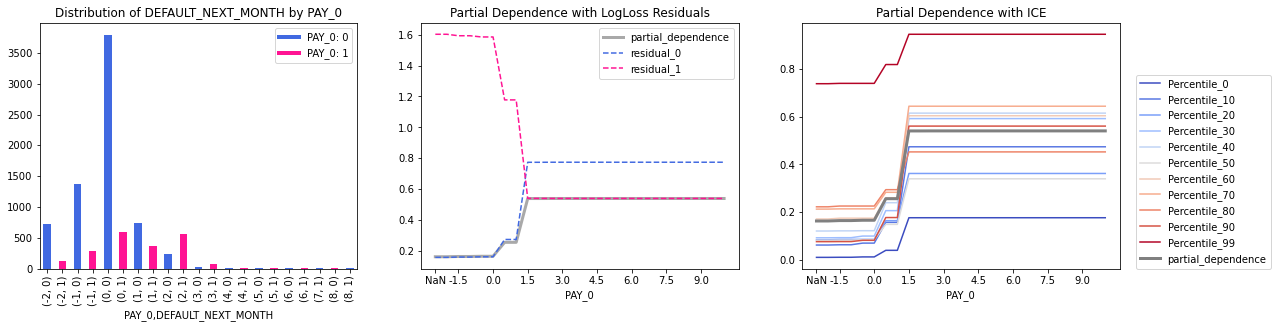

In [23]:
# setup ########################################################################

# tricks to have NaN appear on the x-axis
par_dep_PAY_0.iloc[0, 0] = -2.5
ticks = [-2.5] + list(par_dep_PAY_0['PAY_0'])[2:][::3]
labels = ['NaN'] + list(par_dep_PAY_0['PAY_0'])[2:][::3]

# setup 3-way figure
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=False)
plt.tight_layout()
plt.subplots_adjust(left=0.0, right=2.5, wspace=0.2)
   
# histogram grouped by target class for PAY_0 ##################################

from matplotlib.lines import Line2D # custom legend
custom_lines = [Line2D([0], [0], color='royalblue', lw=4),
                Line2D([0], [0], color='deeppink', lw=4)]

# establish groups and plot w/ custom legend
gb = test.groupby(['PAY_0', y]).count()
gb['color'] = 'deeppink'
gb.iloc[::2, :]['color'] = 'royalblue'
_ = test.groupby(['PAY_0', y]).count().plot(kind='bar', y='ID', legend=False, 
                                            color=gb['color'], 
                                            title='Distribution of DEFAULT_NEXT_MONTH by PAY_0', 
                                            ax=ax0)
_ = ax0.legend(custom_lines, ['PAY_0: 0', 'PAY_0: 1'])
 
# partial dependence and residuals #############################################

_ = ax1.set(xticks=ticks, xticklabels=labels)
_ = par_dep_PAY_0.plot(kind='line', x='PAY_0', y='partial_dependence', 
                       color='darkgrey', linewidth=3,
                       title='Partial Dependence with LogLoss Residuals', 
                       ax=ax1)
_ = par_dep_PAY_0.plot(kind='line', x='PAY_0', y='residual_0', color='royalblue', 
                       linestyle='--', ax=ax1)
_ = par_dep_PAY_0.plot(kind='line', x='PAY_0', y='residual_1', color='deeppink', 
                       linestyle='--', ax=ax1)

# partial dependence and ICE ###################################################

plot_par_dep_ICE('PAY_0', par_dep_PAY_0.drop(['residual_0', 'residual_1'], 
                                             axis=1), 
                  ax2, ticks, labels)

These three plots together are highly informative.


* The monotonicity of the learned GBM response function has been confirmed at many percentiles of model predictions locally and on average globally.


* In general there is not much real data for `PAY_0 > 2`, so predictions in that range are low-confidence, no matter what the modeled probability is. Luckily this model was trained with monotonicity constraints and it carries the predictions from `PAY_0 = 2` forward even into out-of-range data. This seems reasonable. However new customers with `PAY_0 > 2` could also be handed over to human case workers or to a more transparent business rule system to be even more cautious.


* This model treats missing data with lower probability of default than someone who paid their most recent bill in-full. This seems worrisome from a predictive accuracy, model drift, and security perspective. Logically, why would `NaN == -2`? Also, `PAY_0` is the most important variable in the model. Setting it to missing would often result in a customer being seen as likely to pay future bills. Is this prediction behavior prudent from a adversarial, drift, or security standpoint?


* Partial dependence and ICE curves do not diverge, indicating that partial dependence is trustworthy and representative of local behavior and also that strong interactions with other variables are likely not affecting model predictions w.r.t. `PAY_0` _in the observed test set_.


* The customer at the 90th percentile of predicted probability of default has the largest observed swing of prediction values across the domain of `PAY_0`. This information will guide a search for adversarial examples in Section 6.


* The distribution of actual payments and defaults is fairly equal for high values of `PAY_0`, say `PAY_0` > 3, and yet when the scenario in which `PAY_0` is high for everyone is simulated, this leads to both high predicted probabilities and large residuals for `DEFAULT_NEXT_MONTH = 0` individuals. In this case, the inputs to the model changed, but not the labels, so this means that the situation in which someone has paid their bill, but has bad values for `PAY_0`, the model to generates high probabilities of default, and will lead to large errors. *A mechanism for error* has been identified: over-emphasis of a feature. I.e. `PAY_0 > 2` leads to high error when someone does pay their bill the next month.


* This over-emphasis on `PAY_0` could be removed from the model by some means. Potentially by editing the final model artifact, or by injection of missing values or regularization during training, or by missing value injection based on assertions during scoring. 

In [24]:
!pip install pdpbox

You should consider upgrading via the 'c:\users\alexandru\anaconda3\python.exe -m pip install --upgrade pip' command.


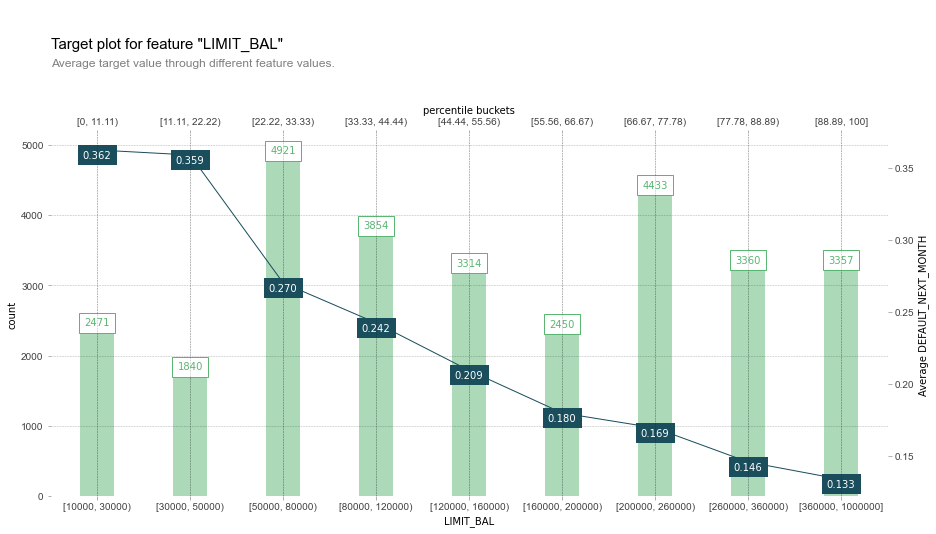

In [25]:
from pdpbox import pdp, get_dataset, info_plots

fig, axes, summary_df = info_plots.target_plot(
    df=data, feature="LIMIT_BAL", feature_name="LIMIT_BAL", target=y, show_percentile=True
)

In [26]:
summary_df

,x,display_column,value_lower,value_upper,percentile_column,percentile_lower,percentile_upper,count,DEFAULT_NEXT_MONTH
0,0,"[10000, 30000)",10000.0,30000.0,"[0, 11.11)",0.00,11.11,2471,0.362202
1,1,"[30000, 50000)",30000.0,50000.0,"[11.11, 22.22)",11.11,22.22,1840,0.358696
2,2,"[50000, 80000)",50000.0,80000.0,"[22.22, 33.33)",22.22,33.33,4921,0.269864
3,3,"[80000, 120000)",80000.0,120000.0,"[33.33, 44.44)",33.33,44.44,3854,0.242086
4,4,"[120000, 160000)",120000.0,160000.0,"[44.44, 55.56)",44.44,55.56,3314,0.209113
5,5,"[160000, 200000)",160000.0,200000.0,"[55.56, 66.67)",55.56,66.67,2450,0.179592
6,6,"[200000, 260000)",200000.0,260000.0,"[66.67, 77.78)",66.67,77.78,4433,0.169186
7,7,"[260000, 360000)",260000.0,360000.0,"[77.78, 88.89)",77.78,88.89,3360,0.145536
8,8,"[360000, 1000000]",360000.0,1000000.0,"[88.89, 100]",88.89,100.00,3357,0.133452


In [27]:
from xgboost import XGBClassifier
est = XGBClassifier(n_jobs=-1, random_state=1) # n_jobs=-1 maximise usage
est.set_params(**params)
model_sk = est.fit(train[X],train[y])

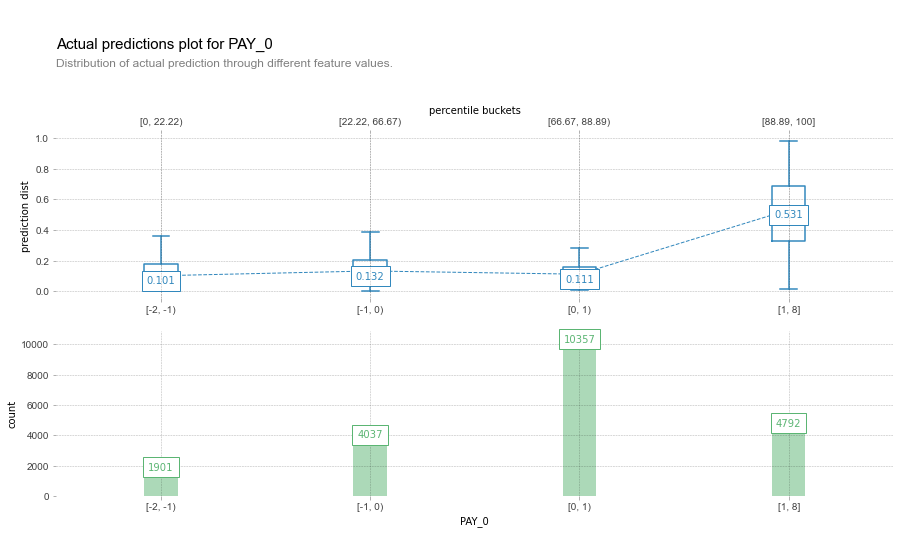

In [28]:
fig, axes, summary_df = info_plots.actual_plot(
    model=model_sk, X=train[X], feature="PAY_0", feature_name="PAY_0", 
    show_percentile=True, predict_kwds={}
)

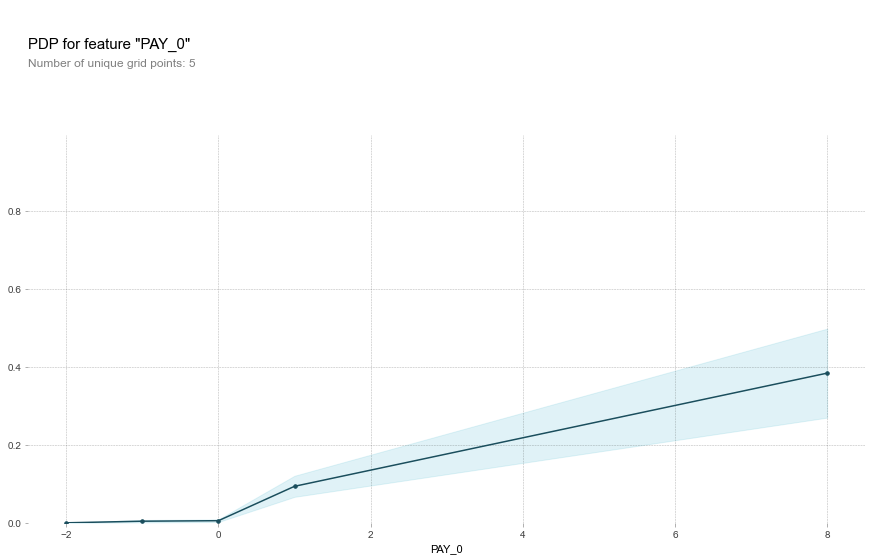

In [29]:
pdp_iso = pdp.pdp_isolate(
    model=model_sk, dataset=train, model_features=X, feature="PAY_0", predict_kwds={}
)
fig, axes = pdp.pdp_plot(pdp_iso, "PAY_0")

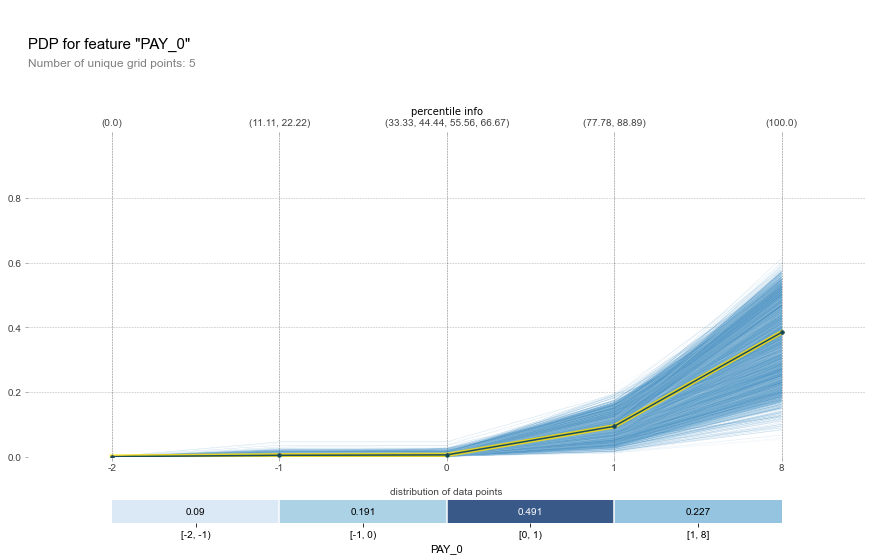

In [83]:
fig, axes = pdp.pdp_plot(
    pdp_iso, "PAY_0", frac_to_plot=0.5, plot_lines=True, x_quantile=True, show_percentile=True, plot_pts_dist=True
)

#### Feature Interaction

When features interact with each other in a prediction model, the prediction cannot be expressed as the sum of the feature effects, because the effect of one feature depends on the value of the other feature.

In [31]:
explainer = shap.TreeExplainer(xgb_model)
inter = shap.TreeExplainer(xgb_model).shap_interaction_values(train[xgb_model.feature_names])

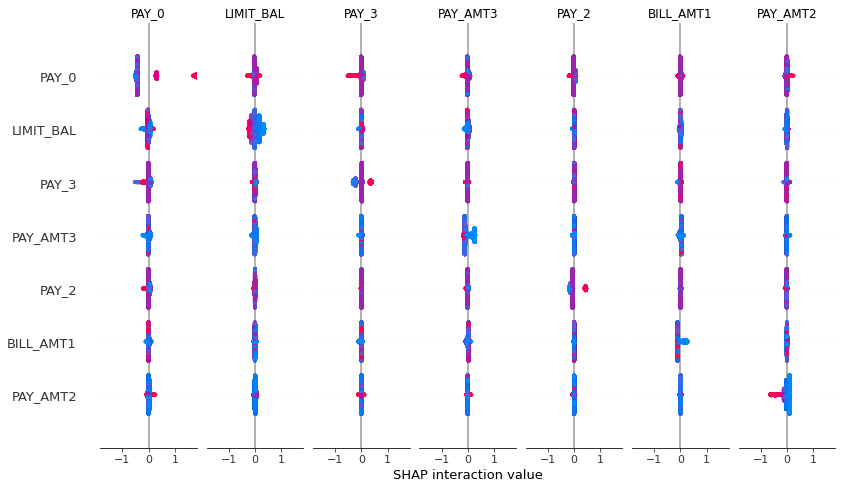

In [32]:
shap.summary_plot(inter, train[xgb_model.feature_names])

### 2.5 Generate reason codes using the Shapley method

Now that the monotonic behavior of the GBM has been verified and compared against domain knowledge and reasonable expectations, a method called Shapley explanations will be used to calculate the local variable importance for any one prediction. Shapley explanations are the only possible consistent local variable importance values. (Here consistency means that if a variable is more important than another variable in a given prediction, the more important variable's Shapley value will not be smaller in magnitude than the less important variable's Shapley value.) Very crucially Shapley values also always sum to the actual prediction of the XGBoost model. When used in a model-specific context for decision tree models, Shapley values are likely the most accurate known local variable importance method available today.

The numeric Shapley values in each column are an estimate of how much each variable contributed to each prediction. Shapley contributions can indicate how a variable and its values were weighted in any given decision by the model. These values are crucially important for machine learning interpretability and are related to "local feature importance", "reason codes", or "turn-down codes." The latter phrases are borrowed from credit scoring. Credit lenders in the U.S. must provide reasons for automatically rejecting a credit application. Reason codes can be easily extracted from Shapley local variable contribution values by ranking the variables that played the largest role in any given decision.

In [33]:
test.reset_index(drop=True, inplace=True)

#### Select most risky customer in test data

One person who might be of immediate interest is the most likely to default customer in the test data. This customer's row will be selected and local variable importance for the corresponding prediction will be analyzed. The most interesting Shapley values are probably those that push this customer's probability of default higher, i.e. the highest positive Shapley values. Those values are plotted below.

In [34]:
decile = 99
row = test[test['ID'] == yhat_percentile_dict[decile]]

# reset test data index to find riskiest customer in shap_values 
# sort to find largest positive contributions
s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(23, 1), columns=['Reason Codes'], index=X)
s_df.sort_values(by='Reason Codes', inplace=True, ascending=False)
s_df

,Reason Codes
PAY_0,1.271218
PAY_2,0.340076
PAY_AMT3,0.327521
BILL_AMT1,0.243392
LIMIT_BAL,0.223668
PAY_AMT2,0.193742
BILL_AMT2,0.188895
PAY_5,0.180911
PAY_AMT1,0.130996
PAY_6,0.129307


#### Plot top local contributions as reason codes

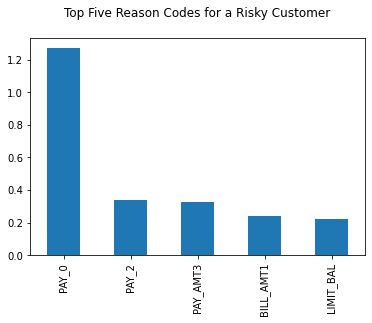

In [35]:
_ = s_df[:5].plot(kind='bar', 
                  title='Top Five Reason Codes for a Risky Customer\n', 
                  legend=False)

For the customer in the test dataset that the GBM predicts as most likely to default, the most important input variables in the prediction are, in descending order, `PAY_0`, `PAY_6`, `PAY_2`, `PAY_5`, and `AGE`.

#### Display customer in question

In [36]:
row # helps understand reason codes

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
4173,14245,10000,1,2,1,50,2,2,7,7,7,7,2400,2400,2400,2400,2400,2400,0,0,0,0,0,0,1


The local contributions for this customer appear reasonable, especially when considering her payment information. Her most recent payment was 2 months late and her payment for 6 months and 5 months previous were 7 months late. Also her credit limit was extremely low, so it's logical that these factors would weigh heavily into the model's prediction for default for this customer.

To generate reason codes for the model's decision, the locally important variable and its value are used together. If this customer was denied future credit based on this model and data, the top five Shapley-based reason codes for the automated decision would be:

 - Most recent payment is 2 months delayed
 - 5th most recent payment is 7 months delayed
 - 6th most recent payment is 7 months delayed
 - 2nd most recent payment is 2 months delayed
 - Credit limit is too low: 10,000 $
 
Of course, credit limits are set by the lender and are used to price-in risk to credit decisions, so using credit limits as reason codes or even in a probability of default model is likely questionable. However, in this small, example data set all input columns were used to generate a better model fit. 

## 3. Robustness

### 3.1 Adversarial Examples

The GBM model is highly sensitive to `PAY_0` values, but what other variable's values have a large impact on model predictions? In this section, brute-force searches will be conducted for rows of data, known as _adversarial examples_, that exert a strong influence on the trained model. Information learned from **Shapley values and ICE** will guide a search for rows that can swing model predictions high and low. These rows are particularly interesting from a drift and security viewpoint. If market conditions change so that high-impact values of important features are more common, e.g. a recession, then this search will help users understand potential future model behavior. Combinations of variables with strong effects can also be recorded and then monitored for in real-time as an active preventative measure against malicious adversarial attacks. Then a search for adversarial examples that minimize model residuals for high-residual customers will also be conducted to confirm, isolate, or remediate any previously known or unknown error mechanisms. Finally, a search for combinations of the demographic variables, `AGE`, `SEX`, `MARRIAGE`, and `EDUCATION`, that have a strong effect on model predictions will be undertaken to help elucidate any unforeseen fairness problems. 

#### Conduct adversarial example search over important variables for an interesting row
In the ICE plot in Section 4, the customer at the 90th percentile of predicted probability of default was shown to have a high degree of variability in their predictions across the values of `PAY_0`. The row will serve as a prototype in a search for adversarial examples.

#### The original row, used as prototype 
For reference, the values for each variable in the prototype row are displayed.

In [37]:
yhat_test[yhat_test['ID'] == yhat_percentile_dict[90]]

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
7779,25962,150000,2,3,1,38,2,0,0,0,0,0,146057,142325,143548,146332,145993,146600,6527,6714,6705,5181,5437,5700,0,0.560431,0.821961


#### Function to find adversarial examples
The search for adversarial examples takes a prototype row, perturbs the values of certain variables in the row, and records the new prediction and residual for each new perturbed row. 

In [38]:
def find_adversaries(xs, frame, model, row_id, oor_proportion=0.1, 
                     resolution=10, verbose=False):  
    
    """ A brute force function to find adversaries. Dynamically generates nested loops
        to populate adversary_frame with perturbed values and their predictions
        and logloss residuals.
        
        ASSUMES global vars y, yhat, and resid have been defined previously.
        
    Args:    
        xs: List of variables over which to find adversaries.
        frame: Pandas DataFrame for which to calculate bounds for adversary search.
               row_id is assumed to be in frame.
        model: Model to use in adversary search.
        row_id: Prototype row on which the search is based.
        oor_proportion: The proportion by which the search can exceed minimum and 
                        maximum values in frame. Must be between 0-1, default 0.1.
        resolution: The number of points across the domain of xs for which 
                    to search for adversaries, default 10 due to deep nesting.
        verbose: Boolean, whether to print generated code statements.
                
    Returns: 
        Frame containing all tested values and their associated predictions 
        and logloss residuals. 
    
    """
    
    # init dicts to hold bin values
    bins_dict = {}
    
    # find boundaries, bins and record 
    for j in xs:
        
        min_ = frame[j].min()
        max_ = frame[j].max()
        min_ = min_ - np.abs(oor_proportion*min_)
        max_ = max_ + np.abs(oor_proportion*max_)
        by = (max_ - min_)/resolution
        # modify max and by 
        # to preserve resolution and actually search up to max
        bins_dict[j] = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))
        bins_dict[j] = np.round_(bins_dict[j], 6)  # reasonable precision
    
    # initialize prototype row
    # deep copy to prevent corruption of original data
    row = frame[frame['ID'] == row_id].copy(deep=True)
    
    # generate nested loops dynamically ############################################
    # to search all vals in all search cols
    
    # init true tab
    # define code variable and init returned Pandas DataFrame, adversary_frame
    tab = '    '
    code = 'global adversary_frame\n'
    code += 'adversary_frame = pd.DataFrame(columns=xs + [yhat, resid])\n'

    # generate for loop statements for search
    for i, j in enumerate(xs):
        code += i*tab + 'for ' + string.ascii_lowercase[i] + ' in ' +\
            str(list(bins_dict[j])) + ':\n'
            
    # generate value assignment statements to perturb search vars
    for k, j in enumerate(xs):
        code += (i + 1)*tab + 'row["' + j + '"] = ' + string.ascii_lowercase[k] +\
            '\n'
    
    # generate progress reporting statements  
    # generate statements for appending test values, preds, and resids to adversary_frame
    # uses only absolute residuals to avoid averaging problems between 0/1 target classes
    code += (i + 1)*tab + 'if (adversary_frame.shape[0] + 1) % 1000 == 0:\n'
    code += (i + 2)*tab +\
        'print("Built %i/%i rows ..." % (adversary_frame.shape[0] + 1, (resolution)**(i+1)))\n'
    code += (i + 1)*tab +\
        'adversary_frame = adversary_frame.append(row, ignore_index=True, sort=False)\n' 
    code += 'print("Scoring ...")\n'
    code += 'adversary_frame[yhat] = model.predict(xgb.DMatrix(adversary_frame[model.feature_names]), ntree_limit=model.best_ntree_limit)\n'
    code += 'adversary_frame[resid] = np.abs(adversary_frame[y]*np.log(adversary_frame[yhat]) - (1 - adversary_frame[y])*np.log(1 - adversary_frame[yhat]))\n'
    code += 'print("Done.")'
    
    if verbose:
        print('Executing:')
        print(code)
        print('--------------------------------------------------------------------------------')
    
    # execute generated code
    exec(code)
    
    return adversary_frame

Due to fluctuations observed in the ICE plot above, the customer at the 90th percentile of probability of default will serve as the prototype row. In the Shapley summary plot in Section 3, `PAY_0`, `PAY_3`, `PAY_AMT1`, and `PAY_AMT2`, exhibit the most extreme local prediction contributions. The search for adversarial examples will be conducted over perturbations of these four variables. The search will consider 10,000 permutations of `PAY_0`, `PAY_3`, `PAY_AMT1`, and `PAY_AMT2` to find adversarial examples with the largest impact on model predictions and to understand the contributions and interactions of these variables in the model in general.

In [39]:
res_ = 10 # keep resolution small to avoid long run time

# four variables with widest Shapley contribs
search_cols = ['PAY_0', 'PAY_3', 'PAY_AMT1', 'PAY_AMT2'] 

# execute search
yhat_adversaries = find_adversaries(search_cols, test, xgb_model, yhat_percentile_dict[90], resolution=res_)

Built 1000/10000 rows ...
Built 2000/10000 rows ...
Built 3000/10000 rows ...
Built 4000/10000 rows ...
Built 5000/10000 rows ...
Built 6000/10000 rows ...
Built 7000/10000 rows ...
Built 8000/10000 rows ...
Built 9000/10000 rows ...
Built 10000/10000 rows ...
Scoring ...
Done.


#### Adversarial examples that minimize model predictions
These, and similar, rows minimize the predicted probability of default for the prototype row. They could be used by a malicious attacker in an integrity attack using hacked or falsified application information to maximize their chance at receiving undeserved credit line increases, loans, or other financially beneficial outcomes. These rows should be recorded and monitored for after the model is deployed.

In [40]:
yhat_adversaries.sort_values(by=yhat).head(n=3)

,PAY_0,PAY_3,PAY_AMT1,PAY_AMT2,p_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_2,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
41,-2.2,-2.2,422799.168,147071.991,0.030411,0.030883,25962.0,150000.0,2.0,3.0,1.0,38.0,0.0,0.0,0.0,0.0,146057.0,142325.0,143548.0,146332.0,145993.0,146600.0,6705.0,5181.0,5437.0,5700.0,0.0
59,-2.2,-2.2,528498.960,1323647.919,0.030411,0.030883,25962.0,150000.0,2.0,3.0,1.0,38.0,0.0,0.0,0.0,0.0,146057.0,142325.0,143548.0,146332.0,145993.0,146600.0,6705.0,5181.0,5437.0,5700.0,0.0
58,-2.2,-2.2,528498.960,1176575.928,0.030411,0.030883,25962.0,150000.0,2.0,3.0,1.0,38.0,0.0,0.0,0.0,0.0,146057.0,142325.0,143548.0,146332.0,145993.0,146600.0,6705.0,5181.0,5437.0,5700.0,0.0


#### Adversarial examples that maximize model predictions
These, and similar, rows maximize the predicted probability of default for the prototype row. They could be used by a malicious attacker in a hacked or falsified application in a denial-of-service (DOS) attack to minimize another customer's chances of receiving credit line increases, loans, or other financially beneficial outcomes. These rows should be recorded and monitored for after the model is deployed.

In [41]:
yhat_adversaries.sort_values(by=yhat).tail(n=3)

,PAY_0,PAY_3,PAY_AMT1,PAY_AMT2,p_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_2,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
9800,8.69,7.48,0.0,0.0,0.598006,0.911318,25962.0,150000.0,2.0,3.0,1.0,38.0,0.0,0.0,0.0,0.0,146057.0,142325.0,143548.0,146332.0,145993.0,146600.0,6705.0,5181.0,5437.0,5700.0,0.0
7700,6.27,6.27,0.0,0.0,0.598006,0.911318,25962.0,150000.0,2.0,3.0,1.0,38.0,0.0,0.0,0.0,0.0,146057.0,142325.0,143548.0,146332.0,145993.0,146600.0,6705.0,5181.0,5437.0,5700.0,0.0
5800,3.85,7.48,0.0,0.0,0.598006,0.911318,25962.0,150000.0,2.0,3.0,1.0,38.0,0.0,0.0,0.0,0.0,146057.0,142325.0,143548.0,146332.0,145993.0,146600.0,6705.0,5181.0,5437.0,5700.0,0.0


#### Function for visual summary of adversary search results.
This function groups the DataFrame by two search variables and uses a custom descriptive statistic to summarize the group in terms of predictions or residuals. The summarized value is then plotted on a surface in terms of the two groupby variables. 

In [42]:
def plot_sm_3d(frame, resolution, search_cols, z_axis_var, stat):

    """Plots 6 small multiples in a grouped subplot to display adversary search 
       results from find_adversaries.
    
    Args:
        frame: Pandas DataFrame containing potential adversaries generated by 
               find_adversaries.
        resolution: The number of points across the domain of the variables in 
                    search_cols in find_adversaries. 
        search_cols: List of search_cols used in find_adversaries.
        z_axis_var: The name of the variable by which to group the frame and
                    that will appear in the title and z-axis label of the 
                    generated plot.
        stat: Groupby stat for z_axis_var and frame.
    
    """
    
    max_ = frame[z_axis_var].max() # establish z-axis high limit
    
    fig = plt.figure(figsize=plt.figaspect(0.67)*2.5) # init 2 x 3 plot

    _2d_shape = (resolution, resolution) # correct shape for 3-D display of 1-D arrays

    # loop through 2-way combos of search_cols
    for i, two_way_combo in enumerate(list(combinations(search_cols, 2))):

        # many unique values exist for each 2-way combo of search_cols values 
        # summarize by stat to plot concisely
        
        # execute groupby
        groups = eval('frame[[two_way_combo[0], two_way_combo[1], z_axis_var]]\
                        .groupby([two_way_combo[0], two_way_combo[1]]).' + stat + '()')

        groups = groups.reset_index() # convert groupby vals to cols (from index)

        ax = fig.add_subplot(2, 3, (i + 1), projection='3d') # subplot placement
            
        # values and labels for each axis
        x = np.asarray(groups[two_way_combo[0]]).reshape(_2d_shape)
        ax.set_xlabel('\n' + two_way_combo[0])
        y = np.asarray(groups[two_way_combo[1]]).reshape(_2d_shape)
        ax.set_ylabel('\n' + two_way_combo[1])
        z = np.asarray(groups[z_axis_var]).reshape(_2d_shape)
        ax.set_zlabel('\n' + stat + ' ' + str(z_axis_var))
        ax.set_zlim3d(0, max_) # ensure constant scale
        
        # plot
        surf = ax.plot_surface(x, y, z, 
                               cmap=cm.coolwarm, 
                               linewidth=0.05, 
                               rstride=1, 
                               cstride=1, 
                               antialiased=True)
        
    
    # main title and display    
    fig.suptitle(stat.title() + ' ' + str(z_axis_var) + ' for ' + str(search_cols))    
    plt.tight_layout()
    _ = plt.show()

#### Maximum predictions across pairs of search variables
The plots below show the maximum model prediction generated by an adversary in terms of values of the search variables.

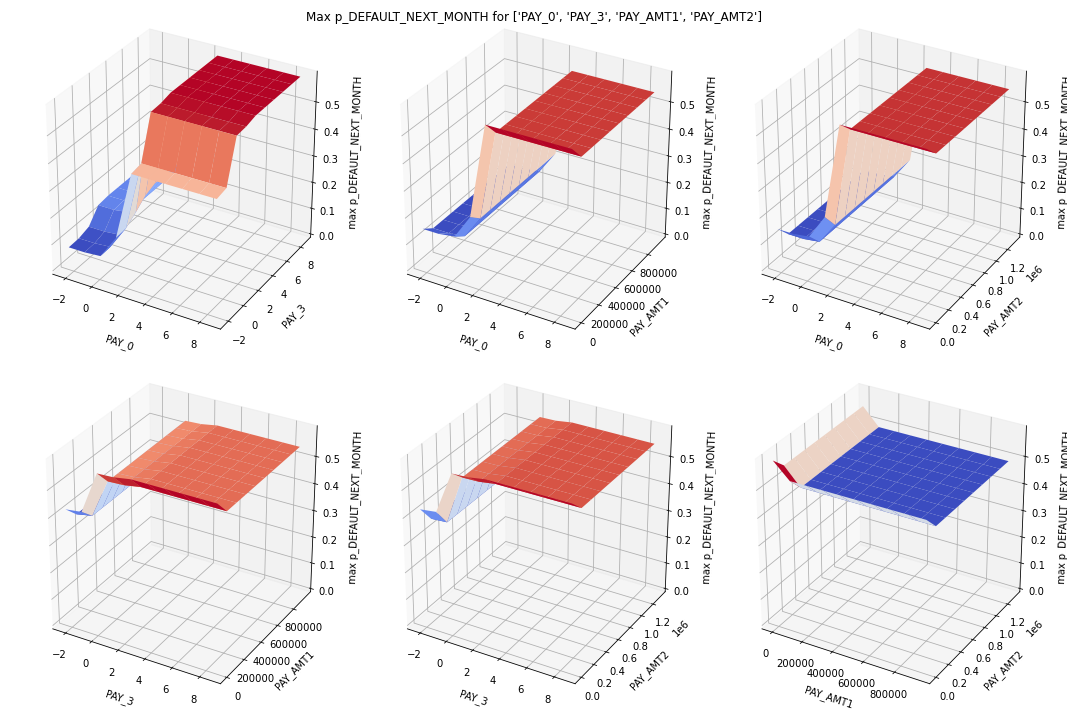

In [43]:
plot_sm_3d(yhat_adversaries, res_, search_cols, yhat, 'max') # plot max prediction

The search has revealed several interesting patterns: 

* The monotonicity of the learned GBM response function was preserved across this set of variables.


* Another potential error mechanism has been discovered: non-robust interaction features. Due to the PDP and ICE for `PAY_0` showing no evidence of strong interactions with other variables, there appear to be some interactions between `PAY_0`, `PAY_AMT1`, and `PAY_AMT2`, which may not be observed in the training or validation data, but that have a strong effect on model predictions. They should be remediated from the model by some method. For instance high `PAY_0` values and high `PAY_AMT1` values seem to have a strong effect on model predictions, but are likely unrealistic and unobserved, because at a certain point, `PAY_AMT1` values exceed a customer's `LIMIT_BAL` -- meaning they cannot technically default. If the impact of this interaction is somehow remediated, potentially by editing the final model artifact or by injection of missing values or regularization during training or missing value injection based on assertions during scoring, that could possibly lead to more accurate model predictions on future data.


* This model is vulnerable to adversarial attack, especially using `PAY_0` and `PAY_3`. Obvious combinations of values for `PAY_0` and `PAY_3` lead to extreme predicted probabilities of default, but so do other combinations of the repayment status and payment amount variables. Perhaps more surprisingly, combinations of low values for the payment amount variables alone can also lead to high predictions. These payment amount value combinations could be the more subtle route for an adversarial denial-of-service (DOS) attack. Active counter-measures should be considered.


* Users should investigate these patterns to get a sense for how their model might perform if data drifts in any of the searched directions.

####  Conduct adversarial example search over high-residual rows

By attempting to decrease the residual of a high-error row, it may be possible to decrease the overall error of the model or to learn more about general error mechanisms in the model.

#### High-residual prototype row
A customer with a high residual will serve as the prototype row for a search to reduce residual values.

In [44]:
resid_percentile_dict = get_percentile_dict(resid, 'ID', yhat_test) # dictionary of row ID and residuals
high_row = yhat_test[yhat_test['ID'] == resid_percentile_dict[80]] # take customer with high residual
high_row #display

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
2468,8513,50000,2,3,2,27,1,2,2,2,0,0,18019,9946,10319,8603,7298,6709,5559,2446,0,260,1000,1214,0,0.437059,0.57458


#### Execute search and visually summarize adversaries
This search will be over the same combinations of `PAY_0`, `PAY_3`, `PAY_AMT1`, and `PAY_AMT2`, but results will be analyzed in terms of minimum residual instead of maximum prediction.

In [45]:
# four variables with widest Shapley contribs
search_cols = ['PAY_0', 'PAY_3', 'PAY_AMT1', 'PAY_AMT2'] 

# search for high-residual adversaries
high_resid_adversaries = find_adversaries(search_cols, test, xgb_model, resid_percentile_dict[80], resolution=res_)

Built 1000/10000 rows ...
Built 2000/10000 rows ...
Built 3000/10000 rows ...
Built 4000/10000 rows ...
Built 5000/10000 rows ...
Built 6000/10000 rows ...
Built 7000/10000 rows ...
Built 8000/10000 rows ...
Built 9000/10000 rows ...
Built 10000/10000 rows ...
Scoring ...
Done.


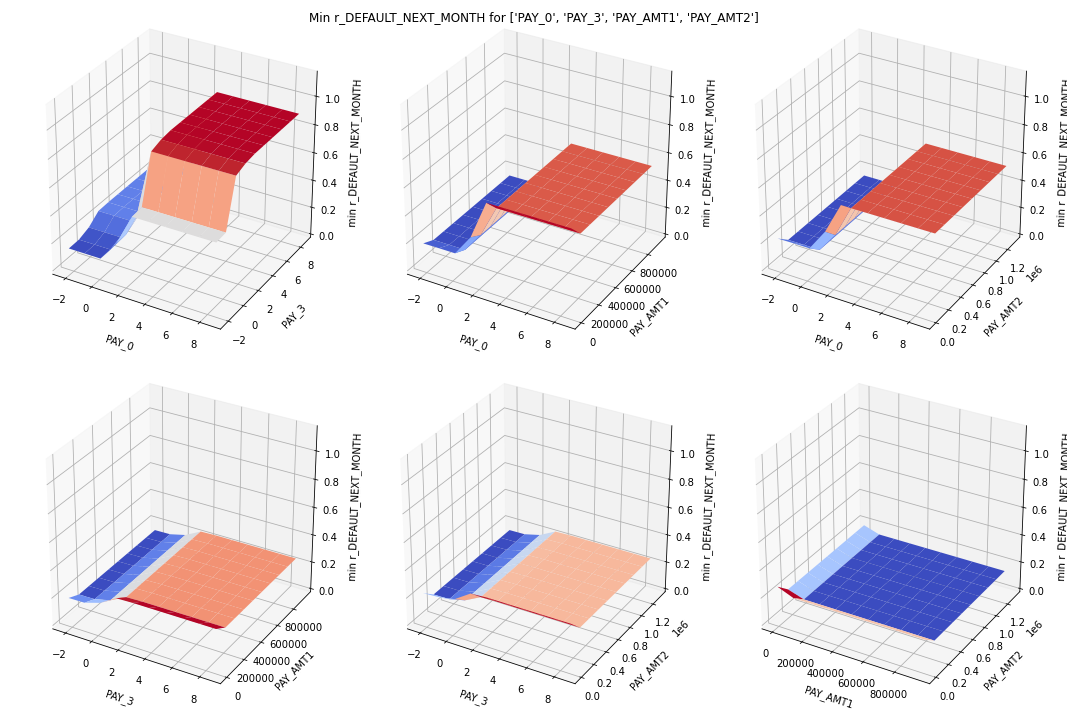

In [46]:
# plot minimum residual
plot_sm_3d(high_resid_adversaries, res_, search_cols, resid, 'min')

These results basically confirm the findings from the search over predictions for these same variables above and from ICE plots. Interactions with low `PAY_3` values or high `PAY_AMT1` and high `PAY_AMT2` values do worsen the over emphasis on `PAY_0` in ways that seem robust, just too dramatic. Interestingly, low `PAY_0` and high `PAY_AMT2` values exhibit the highest residual for this relatively high-risk individual. Also, the same non-robust lack of sensitivity to `PAY_AMT`* variables is observed when `PAY_0` is high. 

####  Conduct adversarial example search over `AGE`, `EDUCATION`, `SEX` and `MARRIAGE` 
This search will look for combinations of demographic segments that may experience disparate impact under the trained model. This is particularly useful in assessing fairness of models.

#### Partial dependence and ICE for AGE
ICE will be used again to select a prototype row with predictions that vary with `AGE`.

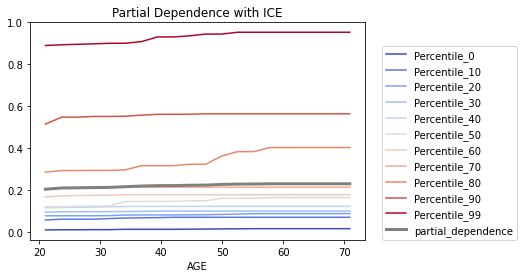

In [47]:
plot_par_dep_ICE('AGE', par_dep_AGE)

#### Prototype row for demographic search
The prototype row for the demographic adversary search is a relatively young married male with a graduate education.

In [48]:
yhat_test[yhat_test['ID'] == yhat_percentile_dict[70]]

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
2735,9466,50000,2,2,1,34,0,0,2,0,0,0,11367,10982,10243,10826,11699,10146,3000,1000,1000,1000,2000,2000,0,0.214374,0.241275


#### Execute and visually summarize adversaries
Search for adversaries whose predictions change widely due to changes in demographic variables. This search will be analyzed in terms of maximum prediction for each tested combination of  `AGE`, `EDUCATION`, `SEX` and `MARRIAGE`.

In [49]:
search_cols = ['AGE', 'EDUCATION', 'SEX', 'MARRIAGE'] 

# execute search
dem_adversaries = find_adversaries(search_cols, test, xgb_model, yhat_percentile_dict[80], resolution=res_)

Built 1000/10000 rows ...
Built 2000/10000 rows ...
Built 3000/10000 rows ...
Built 4000/10000 rows ...
Built 5000/10000 rows ...
Built 6000/10000 rows ...
Built 7000/10000 rows ...
Built 8000/10000 rows ...
Built 9000/10000 rows ...
Built 10000/10000 rows ...
Built 11000/10000 rows ...
Scoring ...
Done.


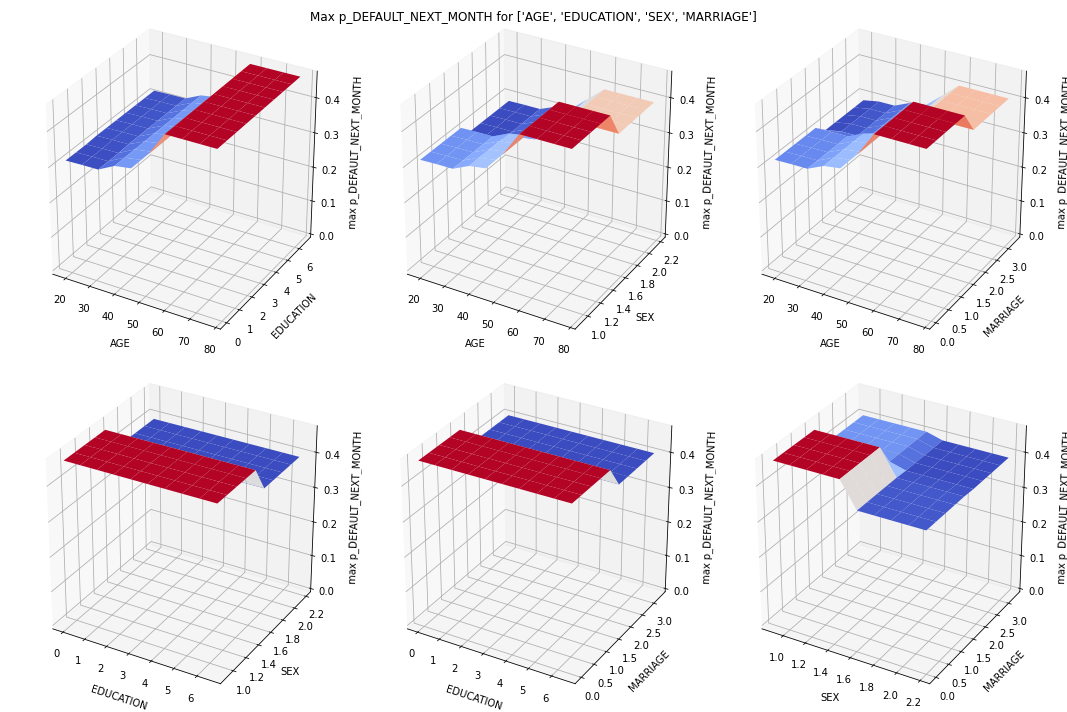

In [50]:
plot_sm_3d(dem_adversaries.iloc[1:10000], res_, search_cols, yhat, 'max') # display max change in predictions

From this search, it can be seen that:


* `EDUCATION` has little impact on model predictions.


* Even high-degree interactions of demographic variables do not swing model predictions drastically compared to other important variables, however several subgroups do appear to have higher predictions for probability of default:

  * Older male customers
  * Older married customers
  * Married male customers
  

* A more detailed fairness analysis of disparate impact should always be conducted for models that affect people, however this adversary search has indicated that certain subgroups maybe be at higher risk of disparate impact for this model.


* If the interactions described above appear non-robust they could be removed from the model by some means, potentially by editing the final model artifact or by injection of missing values or regularization during training or missing value injection based on assertions during scoring.  


* Impersonation attacks seem potentially less damaging than standard adversarial example attacks. 


* These patterns should also be considered in the context of model drift, if the customer population gets older, more male, or contains more married customers, this model indicates much higher levels of risk may be present.

### 3.2 Random Attacks
Random attacks expose a model to random data in an attempt to discover patterns or problems structured or guided searches may not reveal. As the nonlinear or interaction complexity of machine learning models may simply be incomprehensible to human users in some cases, exposure to random data may help reveal unforeseen, unaccounted for, or previously unknown problems. 

#### Function for random attacks

In [51]:
def random_attack(X, frame, model, oor_proportion=0.33, N=10000, 
                  inject_missing=True, missing_proportion=0.15, seed=12345):

    """ Generates random data and scores model on random data.

    Args:
        X: Input variables for model in frame.
        frame: Pandas DataFrame for which to calculate bounds 
               for random data, should contain X.
        model: Model to score on random data.
        oor_proportion: The proportion by which the random values can 
                        exceed minimum and maximum values in frame. 
                        Must be between 0-1, default 0.33.
        N: Number of random samples to generate.
        inject_missing: Whether to randomly inject missing values into 
                        generated frame.
        missing_proportion: The proportion of random values to be  
                            replaced by nan. Must be between 0-1, 
                            default 0.15.
        seed: Seed to enforce reproducibility. 

    Returns:
        Scored random frame.

    """
    
    # init random frame
    random_frame = pd.DataFrame(columns=X, index=np.arange(N))
    
    # find bounds for each j and generate random data
    for j in X:
        
        min_ = frame[j].min()
        max_ = frame[j].max()
        
        np.random.seed(seed) # ensure column bounds are set similary 
        random_frame[j] =\
            np.random.uniform(low=(min_ - np.abs(oor_proportion*min_)),
                              high=(max_ + np.abs(oor_proportion*max_)),
                              size=(N,)) 
        
        # ensure treatment as numeric
        random_frame[j] = pd.to_numeric(random_frame[j])
        
    if inject_missing:
        
        np.random.seed(seed) # ensure nan is injected similarly       
        random_frame =\
            random_frame.mask(np.random.random(random_frame.shape) < missing_proportion)    
    
    # score
    random_frame[yhat] = model.predict(xgb.DMatrix(random_frame[model.feature_names]), 
                                       ntree_limit=model.best_ntree_limit)

    return random_frame

### Random attacks with and without missing values
Partial dependence and ICE revealed a potentially worrisome correlation between low predicted probabilities and missing values. Missingness' effect on the model predictions will also be considered here, as well as problems not considered earlier.

In [52]:
# Run large random attack
N_ = 1000000
randoms_w_miss = random_attack(X, test, xgb_model, N=N_)
randoms_wo_miss = random_attack(X, test, xgb_model, N=N_, inject_missing=False)

#### Confirm the only difference between the two random attacks is the presence of missing values
In the two sets below, the only apparent difference between them appears to be the presence of missing values.

In [53]:
randoms_w_miss.head(n=10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,p_DEFAULT_NEXT_MONTH
0,1.236861e+06,2.519936,7.418336,3.709168,88.773949,9.703894,9.703894,9.703894,8.467505,8.467505,8.467505,1.191164e+06,NaN,NaN,1.096247e+06,1.138731e+06,1.169422e+06,1.080050e+06,1.502795e+06,1.107854e+06,767797.819540,410481.281944,653637.040363,0.626478
1,4.253598e+05,1.299587,2.524677,1.262338,39.493940,1.547795,1.547795,NaN,1.127015,1.127015,NaN,3.927664e+05,3.526220e+05,248248.013587,NaN,3.161840e+05,2.145750e+05,3.675728e+05,5.114453e+05,3.770353e+05,NaN,139698.789881,222451.808588,0.421694
2,2.500798e+05,1.035998,1.467672,0.733836,28.849716,-0.213880,-0.213880,-0.213880,-0.458492,-0.458492,-0.458492,2.203166e+05,1.673894e+05,118629.275610,1.473612e+05,1.385182e+05,8.333130e+03,2.136813e+05,NaN,2.191822e+05,151904.064128,81211.190484,129318.057917,0.072555
3,2.773946e+05,1.077075,1.632391,0.816196,30.508464,0.060652,0.060652,0.060652,-0.211413,-0.211413,-0.211413,2.471904e+05,1.962552e+05,138828.480481,1.736271e+05,1.662049e+05,4.047295e+04,2.376631e+05,3.306873e+05,2.437813e+05,168952.470865,90325.636598,143831.605415,0.044198
4,7.579705e+05,1.799773,NaN,2.265223,59.692383,4.890743,4.890743,NaN,4.135669,4.135669,4.135669,NaN,NaN,494212.099381,6.357475e+05,6.533220e+05,6.059390e+05,6.595967e+05,9.177709e+05,6.765768e+05,468901.133269,250684.663841,NaN,0.502403
5,7.947843e+05,1.855134,4.752447,2.376223,61.927972,5.260745,5.260745,NaN,4.468670,4.468670,4.468670,7.562259e+05,7.430227e+05,NaN,6.711475e+05,6.906368e+05,NaN,6.919182e+05,9.627435e+05,7.097304e+05,491878.236532,NaN,418742.833807,0.504392
6,1.283042e+06,2.589384,7.696826,3.848413,91.578387,10.168043,10.168043,10.168043,8.885239,8.885239,8.885239,1.236600e+06,1.259004e+06,882500.018087,1.140655e+06,NaN,1.223760e+06,1.120596e+06,1.559211e+06,1.149444e+06,NaN,425891.031334,678175.024010,0.667588
7,NaN,1.969822,5.212353,2.606177,66.559312,6.027255,6.027255,6.027255,5.158530,5.158530,5.158530,8.312594e+05,8.236180e+05,577833.279712,7.444837e+05,7.679398e+05,7.389922e+05,7.588769e+05,NaN,NaN,539478.559619,288416.878895,NaN,0.735621
8,9.977282e+05,2.160324,NaN,2.988137,74.252137,NaN,7.300458,7.300458,NaN,NaN,6.304412,9.558929e+05,9.574898e+05,671511.728809,8.662977e+05,8.963430e+05,8.880480e+05,8.700978e+05,1.210665e+06,8.924969e+05,618544.459138,NaN,526575.563663,0.160613
9,8.715690e+05,1.970604,5.215488,2.607744,66.590875,6.032479,6.032479,6.032479,5.163231,5.163231,5.163231,8.317708e+05,8.241672e+05,578217.638156,7.449835e+05,7.684667e+05,7.396038e+05,7.593333e+05,NaN,7.788809e+05,539802.963433,288590.312173,459541.825227,0.689089


In [54]:
randoms_wo_miss.head(n=10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,p_DEFAULT_NEXT_MONTH
0,1.236861e+06,2.519936,7.418336,3.709168,88.773949,9.703894,9.703894,9.703894,8.467505,8.467505,8.467505,1.191164e+06,1.210201e+06,848349.321374,1.096247e+06,1.138731e+06,1.169422e+06,1.080050e+06,1.502795e+06,1.107854e+06,767797.819540,410481.281944,653637.040363,0.600016
1,4.253598e+05,1.299587,2.524677,1.262338,39.493940,1.547795,1.547795,1.547795,1.127015,1.127015,1.127015,3.927664e+05,3.526220e+05,248248.013587,3.159099e+05,3.161840e+05,2.145750e+05,3.675728e+05,5.114453e+05,3.770353e+05,261304.061796,139698.789881,222451.808588,0.603134
2,2.500798e+05,1.035998,1.467672,0.733836,28.849716,-0.213880,-0.213880,-0.213880,-0.458492,-0.458492,-0.458492,2.203166e+05,1.673894e+05,118629.275610,1.473612e+05,1.385182e+05,8.333130e+03,2.136813e+05,2.973188e+05,2.191822e+05,151904.064128,81211.190484,129318.057917,0.036047
3,2.773946e+05,1.077075,1.632391,0.816196,30.508464,0.060652,0.060652,0.060652,-0.211413,-0.211413,-0.211413,2.471904e+05,1.962552e+05,138828.480481,1.736271e+05,1.662049e+05,4.047295e+04,2.376631e+05,3.306873e+05,2.437813e+05,168952.470865,90325.636598,143831.605415,0.044198
4,7.579705e+05,1.799773,4.530446,2.265223,59.692383,4.890743,4.890743,4.890743,4.135669,4.135669,4.135669,7.200066e+05,7.041186e+05,494212.099381,6.357475e+05,6.533220e+05,6.059390e+05,6.595967e+05,9.177709e+05,6.765768e+05,468901.133269,250684.663841,399182.103899,0.600016
5,7.947843e+05,1.855134,4.752447,2.376223,61.927972,5.260745,5.260745,5.260745,4.468670,4.468670,4.468670,7.562259e+05,7.430227e+05,521435.711728,6.711475e+05,6.906368e+05,6.492556e+05,6.919182e+05,9.627435e+05,7.097304e+05,491878.236532,262968.719048,418742.833807,0.600016
6,1.283042e+06,2.589384,7.696826,3.848413,91.578387,10.168043,10.168043,10.168043,8.885239,8.885239,8.885239,1.236600e+06,1.259004e+06,882500.018087,1.140655e+06,1.185540e+06,1.223760e+06,1.120596e+06,1.559211e+06,1.149444e+06,796621.477285,425891.031334,678175.024010,0.600016
7,8.710493e+05,1.969822,5.212353,2.606177,66.559312,6.027255,6.027255,6.027255,5.158530,5.158530,5.158530,8.312594e+05,8.236180e+05,577833.279712,7.444837e+05,7.679398e+05,7.389922e+05,7.588769e+05,1.055911e+06,7.784128e+05,539478.559619,288416.878895,459265.655716,0.600016
8,9.977282e+05,2.160324,5.976275,2.988137,74.252137,7.300458,7.300458,7.300458,6.304412,6.304412,6.304412,9.558929e+05,9.574898e+05,671511.728809,8.662977e+05,8.963430e+05,8.880480e+05,8.700978e+05,1.210665e+06,8.924969e+05,618544.459138,330687.214869,526575.563663,0.600016
9,8.715690e+05,1.970604,5.215488,2.607744,66.590875,6.032479,6.032479,6.032479,5.163231,5.163231,5.163231,8.317708e+05,8.241672e+05,578217.638156,7.449835e+05,7.684667e+05,7.396038e+05,7.593333e+05,1.056546e+06,7.788809e+05,539802.963433,288590.312173,459541.825227,0.600016


#### Plot ranked predictions with a reference line
The predictions of the model on the random attack dataset are ranked from lowest to highest and plotted in two dimensions, with the x-axis simply being the ranked row index. This technique allows large amounts of information to be summarized in just two dimensions. The ranked predictions are compared to a linearly increasing reference line.

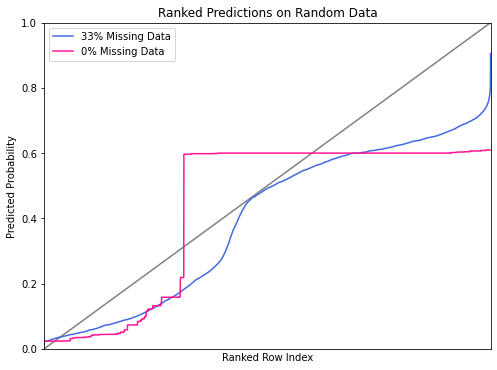

In [55]:
fig, ax = plt.subplots(figsize=(8, 6)) # init plot

# 45-degree reference line
_ = ax.plot(np.linspace(*[0, N_]), np.linspace(*[0, 1]), c='grey', linestyle='-')

# sorted preds w/ missing
_ = randoms_w_miss.sort_values(by=yhat).reset_index().plot(y=yhat, ax=ax,
                                                           title='Ranked Predictions on Random Data',
                                                           color='royalblue',
                                                           label='33% Missing Data')

# sorted preds w/o missing
_ = randoms_wo_miss.sort_values(by=yhat).reset_index().plot(y=yhat, ax=ax,
                                                            label='0% Missing Data',
                                                            color='deeppink')
# margins and axes decoration
_ = ax.margins(x=0, y=0) 
_ = ax.get_xaxis().set_ticks([])
_ = ax.set_xlabel('Ranked Row Index')
_ = ax.set_ylabel('Predicted Probability')

These results confirm the model treats customers with missing data quite differently than those without missing data. Missing values appear to increase output probabilities for low and high predicted probabilities, but seem to decrease model output for medium range predictions relative to rows without missing data. If missing data were to be allowed in credit applications, or could be hacked into the process, missingness could be used in an adversarial attack to alter the model's predictions. Also, if missingness was to somehow become more common in future data, that would have a notable impact on future model predictions. 

Another interesting result of the random attack is that adversaries that can force the model to generate nearly any predicted probability are now known. So, aside from general observations regarding missing values, the adversarial examples of interest seem to be on the extreme low side for both missing and non-missing cases, in the middle range of model output for rows without missing data, and the in the extreme high range of rows with missing data. A few examples of random adversaries are displayed below.

### Low-range non-missing random adversarial examples

In [56]:
randoms_wo_miss.sort_values(by=yhat).head(n=10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,p_DEFAULT_NEXT_MONTH
385700,207028.240773,0.971257,1.208055,0.604028,26.235327,-0.646575,-0.646575,-0.646575,-0.847917,-0.847917,-0.847917,177960.211399,121893.424843,86792.877894,105962.952577,94880.720810,-42323.118591,175883.163350,244725.997353,180410.953999,125033.706568,66845.717521,106442.946082,0.02344
13489,208942.581769,0.974136,1.219599,0.609800,26.351579,-0.627334,-0.627334,-0.627334,-0.830601,-0.830601,-0.830601,179843.642015,123916.463329,88208.524018,107803.777395,96821.118209,-40070.623718,177563.906657,247064.604269,182134.964972,126228.531369,67484.496642,107460.117173,0.02344
775609,210842.295700,0.976992,1.231055,0.615528,26.466943,-0.608241,-0.608241,-0.608241,-0.813417,-0.813417,-0.813417,181712.681747,125924.044218,89613.353498,109630.536871,98746.689454,-37835.339669,179231.807770,249385.342398,183845.803151,127414.226772,68118.394989,108469.516281,0.02344
610022,208008.253747,0.972731,1.213965,0.606982,26.294840,-0.636725,-0.636725,-0.636725,-0.839053,-0.839053,-0.839053,178924.400352,122929.083573,87517.592859,106905.330246,95874.072899,-41169.993727,176743.590124,245923.205753,181293.530889,125645.375967,67172.729181,106963.668810,0.02344
654693,208160.404129,0.972959,1.214883,0.607441,26.304080,-0.635196,-0.635196,-0.635196,-0.837676,-0.837676,-0.837676,179074.094000,123089.873149,87630.107348,107051.637618,96028.294224,-40990.967129,176877.174338,246109.076471,181430.553984,125740.339744,67223.498865,107044.512803,0.02344
789328,210366.636261,0.976277,1.228187,0.614093,26.438058,-0.613022,-0.613022,-0.613022,-0.817720,-0.817720,-0.817720,181244.702660,125421.376535,89261.605589,109173.144117,98264.555737,-38395.020755,178814.190731,248804.264911,183417.435324,127117.346699,67959.676496,108216.778116,0.02344
457318,206761.789310,0.970856,1.206448,0.603224,26.219146,-0.649253,-0.649253,-0.649253,-0.850328,-0.850328,-0.850328,177698.062259,121611.844097,86595.838295,105706.733613,94610.642632,-42636.636693,175649.225658,244400.493570,180170.994009,124867.402437,66756.807744,106301.369044,0.02344
232179,205777.354753,0.969376,1.200512,0.600256,26.159365,-0.659147,-0.659147,-0.659147,-0.859232,-0.859232,-0.859232,176729.523119,120571.512724,85867.853590,104760.104163,93612.808778,-43794.964178,174784.916845,243197.883655,179284.435145,124252.973333,66428.320687,105778.296941,0.02344
429812,207145.780307,0.971434,1.208764,0.604382,26.242465,-0.645393,-0.645393,-0.645393,-0.846854,-0.846854,-0.846854,178075.853051,122017.638345,86879.797823,106075.978256,94999.860193,-42184.816586,175986.360108,244869.586592,180516.807369,125107.068185,66884.938224,106505.399853,0.02344
727852,206347.599010,0.970233,1.203951,0.601975,26.193994,-0.653416,-0.653416,-0.653416,-0.854074,-0.854074,-0.854074,177290.559786,121174.135810,86289.546524,105308.449407,94190.814721,-43123.990581,175285.576979,243894.508324,179797.983859,124608.887970,66618.600332,106081.292057,0.02344


#### Low-range random adversarial examples with missingness

In [57]:
randoms_w_miss.sort_values(by=yhat).head(n=10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,p_DEFAULT_NEXT_MONTH
260613,1.072209e+06,2.272329,NaN,3.212710,78.775115,NaN,NaN,NaN,NaN,NaN,NaN,1.029171e+06,1.036199e+06,726589.741879,9.379180e+05,9.718373e+05,9.756849e+05,9.354899e+05,1.301652e+06,9.595724e+05,665031.059729,355539.954638,566150.258007,0.013045
333533,1.256621e+06,2.549651,7.537496,3.768748,89.973905,NaN,NaN,NaN,NaN,NaN,NaN,1.210605e+06,1.231083e+06,862961.631053,1.115248e+06,1.158759e+06,1.192672e+06,1.097399e+06,1.526935e+06,1.125650e+06,780130.809891,417074.764708,664136.287829,0.015389
666987,7.130904e+05,1.732281,NaN,2.129901,NaN,NaN,4.439669,NaN,3.729702,NaN,NaN,6.758511e+05,6.566901e+05,461023.419572,5.925908e+05,6.078309e+05,5.531310e+05,6.201930e+05,8.629442e+05,6.361587e+05,440889.431024,235709.003382,375335.349342,0.017954
761433,1.237977e+06,2.521615,7.425068,3.712534,NaN,NaN,NaN,NaN,8.477602,NaN,NaN,1.192263e+06,1.211380e+06,849174.773528,NaN,1.139862e+06,1.170735e+06,1.081030e+06,1.504159e+06,1.108860e+06,768494.512512,410853.749040,654230.144849,0.018281
883452,8.531462e+05,1.942900,5.104391,2.552196,NaN,NaN,NaN,NaN,4.996587,NaN,NaN,8.136455e+05,8.046984e+05,564594.077055,NaN,7.497931e+05,7.179267e+05,7.431585e+05,1.034040e+06,7.622898e+05,528304.490481,282442.980418,449753.014114,0.018281
406230,3.172202e+05,1.136965,NaN,0.936277,NaN,0.460923,NaN,NaN,0.148831,NaN,NaN,2.863729e+05,2.383421e+05,168279.274774,2.119232e+05,2.065725e+05,8.733336e+04,2.726289e+05,3.793392e+05,2.796472e+05,193809.346324,103614.658582,164992.611729,0.018751
35709,2.614165e+05,1.053047,NaN,0.768018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.314703e+05,1.793699e+05,127012.722362,1.582625e+05,1.500092e+05,2.167239e+04,2.236347e+05,3.111680e+05,2.293917e+05,158979.808496,84994.036104,135341.738226,0.018751
585563,2.520376e+05,1.038943,NaN,0.739739,NaN,NaN,NaN,NaN,-0.440782,NaN,NaN,2.222429e+05,1.694585e+05,120077.123299,1.492439e+05,1.405028e+05,1.063686e+04,2.154003e+05,2.997106e+05,2.209454e+05,153126.067492,81864.499851,130358.366500,0.018751
239648,2.454212e+05,1.028993,1.439579,0.719790,NaN,-0.260701,-0.260701,NaN,-0.500631,NaN,NaN,2.157332e+05,1.624664e+05,115184.285796,1.428815e+05,1.337962e+05,2.851660e+03,2.095912e+05,2.916278e+05,2.149868e+05,148996.445342,79656.714740,126842.761309,0.018837
448317,2.454590e+05,1.029050,1.439807,0.719903,NaN,-0.260322,-0.260322,NaN,-0.500290,-0.50029,NaN,2.157704e+05,1.625063e+05,115212.214249,1.429178e+05,1.338345e+05,2.896099e+03,2.096244e+05,2.916739e+05,2.150208e+05,149020.017340,79669.316839,126862.828482,0.018837


#### High-range random adversarial examples with missingness

In [58]:
randoms_w_miss.sort_values(by=yhat).tail(n=3)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,p_DEFAULT_NEXT_MONTH
771622,NaN,1.485305,3.269413,NaN,46.993565,2.789022,2.789022,2.789022,2.244120,2.244120,2.244120,NaN,483131.660679,339573.787414,434664.711994,NaN,359887.358174,NaN,NaN,488254.174254,NaN,180907.532981,288071.270575,0.880665
4745,465998.587211,1.360701,2.769744,NaN,41.961812,1.956241,1.956241,1.956241,1.494617,1.494617,1.494617,NaN,395568.271156,278300.225956,354988.096007,357375.954454,NaN,NaN,NaN,NaN,NaN,NaN,244044.946260,0.893915
220302,713704.863636,NaN,NaN,NaN,57.004263,4.445845,4.445845,4.445845,3.735260,3.735260,3.735260,NaN,657339.466446,461477.847446,593181.741974,NaN,553854.102728,NaN,NaN,NaN,NaN,235914.053946,375661.865191,0.905420


Any of the above values could be used in an adversarial integrity or DOS attack and should potentially be monitored for after the model is deployed. These values could also be used to find non-sensical, non-robust interactions that can cause unwanted model behavior. If these interactions can be isolated, they can be potentially remediated from model mechanisms, potentially by editing the final model artifact or by injection of missing values or regularization during training or missing value injection based on assertions during scoring.  

#### Conclusion

In this model debugging exercise several accuracy, drift, and security patterns were discovered.


* Monotonicity constraints held in all tested scenarios.


* Two types of error mechanisms were identified:
  * Over-emphasis of an important feature.
  * Non-robust interactions.


* In-depth analysis with partial dependence and ICE found an over-emphasis on `PAY_0`.


* Searching for adversarial examples found:
  * Specific features and combinations of features that can swing model predictions.
  * Specific features and combinations of features that can reduce the residual of high-residual customers.
  * Specific features and combinations of features that should be investigated further for disparate impact.
  * A non-robust interaction between `PAY_0`, `PAY_3`, `PAY_AMT1` and `PAY_AMT2` in which large payment amounts do not decrease probability of default.
  * That randomly-generated adversaries can make the model predict nearly any probability.
  * That missing data can drastically affect model predictions.


* To make the model more accurate, the final model artifact could be edited to remove over-emphasis on certain features or to remove model dependence on non-robust features.


* To make the model more accurate, missing values could be injected at training time or regularization could be used to lessen the impact of overly-important features or assertions could be appended to model scoring logic to inject missing values into non-robust interactions at scoring time. 